O3 농도 예측 모델의 학습 및 모델 예측 테스트 코드

VER: 
    
    v2

SETUP:

    In[NOx, SOX, VOC, NH3, PM2.5]
    Out[pred. O3]

STRUCTURE:

    Conditional U-Net
    (Boundary Condition BC=1)

In [1]:
# Import
import os
import sys
sys.path.append('/home/user/workdir/CMAQ_Emulator/main')

import numpy as np
import pandas as pd
import netCDF4 as nc
from netCDF4 import Dataset

from sklearn.model_selection import train_test_split
import tensorflow as tf

from src.model.cmaqnet_cond_unet import build_model
from sklearn.metrics import mean_squared_error, r2_score

import geopandas as gpd
from shapely.geometry import Point
import matplotlib as mpl
import matplotlib.pyplot as plt

2025-02-27 09:48:43.703744: I tensorflow/core/util/port.cc:111] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-02-27 09:48:43.735259: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-02-27 09:48:43.735289: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-02-27 09:48:43.735307: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-02-27 09:48:43.741753: I tensorflow/core/platform/cpu_feature_g

# Training

In [2]:
dataset_2013 = pd.read_csv('/home/user/workdir/CMAQ_Emulator/main/resources/ctrl/precursor_control_2013.csv')
dataset_2013['Boundary'] = 1.0

ctrl_data = pd.concat([dataset_2013], axis=0)
ctrl_data = ctrl_data.reset_index(drop=True).values
emis_data, boundary_data = ctrl_data[:, :17*5], ctrl_data[:, 17*5]
# -------------
label_path_2013 = '/home/user/workdir/CMAQ_Emulator/main/datasets/concentration/2013'

label_path = []
for i in range(1, 120): 
    label_path.append(os.path.join(label_path_2013, '1.00', f'ACONC.{i}'))

label_data = []
for path in label_path:
    with nc.Dataset(path) as f:
        label_data.append(f.variables['O3'][:].data.squeeze())  # ncf 파일 내 목적변수를 지정 
label_data = np.array(label_data).reshape(len(label_data), 82, 67, 1)

In [3]:
from src.model.cmaqnet_cond_unet import build_model

model_path = '/home/user/workdir/CMAQ_Emulator/main/src/model/o3_prediction/v2/final_model'  # 모델 저장 경로

epochs = 1000  # 훈련 반복 횟수
batch_size = 32  # 배치 크기
test_split = 0.4  # 테스트 데이터 비율 (50%)
random_seed = 42  # 랜덤 시드

X_emis_train, X_emis_test, X_boundary_train, X_boundary_test, y_train, y_test = train_test_split(emis_data, boundary_data, label_data, test_size=test_split, random_state=random_seed)

gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        print("Memory growth enabled for GPUs")
    except RuntimeError as e:
        print(e)

strategy = tf.distribute.MirroredStrategy()
with strategy.scope():
    model = build_model(
        ctrl_dim=17*5,
        cond_dim=[1],
        emb_dims=[128],
        emb_type=['normal'],
        out_channel=1,
        hidden_size=[128, 96],
        hidden_depth=4,
        in_filters=20,
        kernel_size=3,
        activation='silu',
        dropout=0.0,
        use_abs=True
    )
    model.compile(
        optimizer=tf.keras.optimizers.Adam(1e-3),
        loss=tf.keras.losses.MeanSquaredError(),
    )
    
# define callback
def scheduler(epoch, lr):
    if epoch <= 1000: return 1e-3
    else: return 1e-4
callback_lr = tf.keras.callbacks.LearningRateScheduler(scheduler)

callback_ckpt = tf.keras.callbacks.ModelCheckpoint(
    filepath='/home/user/workdir/CMAQ_Emulator/main/src/model/o3_prediction/v2/final_model-{epoch:02d}-{val_loss:.4f}',
    monitor='val_loss',
    save_best_only=True,
    save_weights_only=False,
    mode='min',
    save_freq='epoch')

history = model.fit(
    x=[X_emis_train, X_boundary_train],   # 입력 데이터 (지역 별 배출량, 경계 조건 값)
    y=y_train,                                          # 입력 데이터의 Label 값 (netCDF에서 PM2.5 값)
    epochs=epochs,
    batch_size=batch_size,
    validation_data=[[X_emis_test, X_boundary_test], y_test], # test 데이터
    callbacks=[callback_lr, callback_ckpt])
model.save(model_path)

def plot_loss(history):
    plt.figure(figsize=(10, 6))
    
    # 학습 손실
    plt.plot(history.history['loss'], label='Training Loss', color='blue')
    # 검증 손실
    plt.plot(history.history['val_loss'], label='Validation Loss', color='orange')

    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(alpha=0.3)
    plt.show()
''' '''

Memory growth enabled for GPUs
INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1', '/job:localhost/replica:0/task:0/device:GPU:2', '/job:localhost/replica:0/task:0/device:GPU:3')


2025-02-27 09:48:46.411943: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1886] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 18889 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3090, pci bus id: 0000:19:00.0, compute capability: 8.6
2025-02-27 09:48:46.413495: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1886] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 18891 MB memory:  -> device: 1, name: NVIDIA GeForce RTX 3090, pci bus id: 0000:1a:00.0, compute capability: 8.6
2025-02-27 09:48:46.415011: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1886] Created device /job:localhost/replica:0/task:0/device:GPU:2 with 18891 MB memory:  -> device: 2, name: NVIDIA GeForce RTX 3090, pci bus id: 0000:67:00.0, compute capability: 8.6
2025-02-27 09:48:46.416487: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1886] Created device /job:localhost/replica:0/task:0/device:GPU:3 with 18822 MB memory:  -> device: 3, name: NVIDIA GeForce RTX 3090

INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Redu

2025-02-27 09:49:12.767928: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:442] Loaded cuDNN version 8907
2025-02-27 09:49:12.787120: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:442] Loaded cuDNN version 8907
2025-02-27 09:49:12.811823: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:442] Loaded cuDNN version 8907
2025-02-27 09:49:12.886468: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:442] Loaded cuDNN version 8907
2025-02-27 09:49:15.915071: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7fb036334bc0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2025-02-27 09:49:15.915128: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 3090, Compute Capability 8.6
2025-02-27 09:49:15.915142: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (1): NVIDIA GeForce RTX 3090, Compute Capability 8.6
2025-02-27 09:49:15.91515

3/3 [==============================] - ETA: 0s - loss: 1.0324 INFO:tensorflow:Assets written to: /home/user/workdir/CMAQ_Emulator/main/src/model/o3_prediction/v2/final_model-01-0.00/assets


INFO:tensorflow:Assets written to: /home/user/workdir/CMAQ_Emulator/main/src/model/o3_prediction/v2/final_model-01-0.00/assets


3/3 [==============================] - 47s 7s/step - loss: 1.0324 - val_loss: 0.0017 - lr: 0.0010
Epoch 2/1000
3/3 [==============================] - 0s 193ms/step - loss: 0.1149 - val_loss: 0.0017 - lr: 0.0010
Epoch 3/1000
3/3 [==============================] - 0s 202ms/step - loss: 0.0395 - val_loss: 0.0029 - lr: 0.0010
Epoch 4/1000
3/3 [==============================] - 0s 212ms/step - loss: 0.0196 - val_loss: 0.0124 - lr: 0.0010
Epoch 5/1000
3/3 [==============================] - 0s 196ms/step - loss: 0.0114 - val_loss: 0.0443 - lr: 0.0010
Epoch 6/1000
3/3 [==============================] - 1s 229ms/step - loss: 0.0071 - val_loss: 0.0943 - lr: 0.0010
Epoch 7/1000
3/3 [==============================] - 0s 187ms/step - loss: 0.0039 - val_loss: 0.1345 - lr: 0.0010
Epoch 8/1000
3/3 [==============================] - 0s 199ms/step - loss: 0.0023 - val_loss: 0.1487 - lr: 0.0010
Epoch 9/1000
3/3 [==============================] - 0s 195ms/step - loss: 0.0019 - val_loss: 0.1415 - lr: 0.001

INFO:tensorflow:Assets written to: /home/user/workdir/CMAQ_Emulator/main/src/model/o3_prediction/v2/final_model-50-0.00/assets


3/3 [==============================] - 10s 5s/step - loss: 3.2776e-04 - val_loss: 0.0016 - lr: 0.0010
Epoch 51/1000
3/3 [==============================] - ETA: 0s - loss: 2.9809e-04INFO:tensorflow:Assets written to: /home/user/workdir/CMAQ_Emulator/main/src/model/o3_prediction/v2/final_model-51-0.00/assets


INFO:tensorflow:Assets written to: /home/user/workdir/CMAQ_Emulator/main/src/model/o3_prediction/v2/final_model-51-0.00/assets


3/3 [==============================] - 9s 5s/step - loss: 2.9809e-04 - val_loss: 0.0015 - lr: 0.0010
Epoch 52/1000
3/3 [==============================] - ETA: 0s - loss: 2.6232e-04INFO:tensorflow:Assets written to: /home/user/workdir/CMAQ_Emulator/main/src/model/o3_prediction/v2/final_model-52-0.00/assets


INFO:tensorflow:Assets written to: /home/user/workdir/CMAQ_Emulator/main/src/model/o3_prediction/v2/final_model-52-0.00/assets


3/3 [==============================] - 9s 5s/step - loss: 2.6232e-04 - val_loss: 0.0015 - lr: 0.0010
Epoch 53/1000
3/3 [==============================] - ETA: 0s - loss: 2.8317e-04INFO:tensorflow:Assets written to: /home/user/workdir/CMAQ_Emulator/main/src/model/o3_prediction/v2/final_model-53-0.00/assets


INFO:tensorflow:Assets written to: /home/user/workdir/CMAQ_Emulator/main/src/model/o3_prediction/v2/final_model-53-0.00/assets


3/3 [==============================] - 9s 5s/step - loss: 2.8317e-04 - val_loss: 0.0014 - lr: 0.0010
Epoch 54/1000
3/3 [==============================] - ETA: 0s - loss: 3.6542e-04INFO:tensorflow:Assets written to: /home/user/workdir/CMAQ_Emulator/main/src/model/o3_prediction/v2/final_model-54-0.00/assets


INFO:tensorflow:Assets written to: /home/user/workdir/CMAQ_Emulator/main/src/model/o3_prediction/v2/final_model-54-0.00/assets


3/3 [==============================] - 9s 5s/step - loss: 3.6542e-04 - val_loss: 0.0013 - lr: 0.0010
Epoch 55/1000
3/3 [==============================] - ETA: 0s - loss: 3.1331e-04INFO:tensorflow:Assets written to: /home/user/workdir/CMAQ_Emulator/main/src/model/o3_prediction/v2/final_model-55-0.00/assets


INFO:tensorflow:Assets written to: /home/user/workdir/CMAQ_Emulator/main/src/model/o3_prediction/v2/final_model-55-0.00/assets


3/3 [==============================] - 10s 5s/step - loss: 3.1331e-04 - val_loss: 0.0012 - lr: 0.0010
Epoch 56/1000
3/3 [==============================] - ETA: 0s - loss: 3.2703e-04INFO:tensorflow:Assets written to: /home/user/workdir/CMAQ_Emulator/main/src/model/o3_prediction/v2/final_model-56-0.00/assets


INFO:tensorflow:Assets written to: /home/user/workdir/CMAQ_Emulator/main/src/model/o3_prediction/v2/final_model-56-0.00/assets


3/3 [==============================] - 10s 5s/step - loss: 3.2703e-04 - val_loss: 0.0012 - lr: 0.0010
Epoch 57/1000
3/3 [==============================] - ETA: 0s - loss: 2.6479e-04INFO:tensorflow:Assets written to: /home/user/workdir/CMAQ_Emulator/main/src/model/o3_prediction/v2/final_model-57-0.00/assets


INFO:tensorflow:Assets written to: /home/user/workdir/CMAQ_Emulator/main/src/model/o3_prediction/v2/final_model-57-0.00/assets


3/3 [==============================] - 9s 5s/step - loss: 2.6479e-04 - val_loss: 0.0012 - lr: 0.0010
Epoch 58/1000
3/3 [==============================] - ETA: 0s - loss: 2.6935e-04INFO:tensorflow:Assets written to: /home/user/workdir/CMAQ_Emulator/main/src/model/o3_prediction/v2/final_model-58-0.00/assets


INFO:tensorflow:Assets written to: /home/user/workdir/CMAQ_Emulator/main/src/model/o3_prediction/v2/final_model-58-0.00/assets


3/3 [==============================] - 10s 5s/step - loss: 2.6935e-04 - val_loss: 0.0011 - lr: 0.0010
Epoch 59/1000
3/3 [==============================] - ETA: 0s - loss: 2.2942e-04INFO:tensorflow:Assets written to: /home/user/workdir/CMAQ_Emulator/main/src/model/o3_prediction/v2/final_model-59-0.00/assets


INFO:tensorflow:Assets written to: /home/user/workdir/CMAQ_Emulator/main/src/model/o3_prediction/v2/final_model-59-0.00/assets


3/3 [==============================] - 9s 5s/step - loss: 2.2942e-04 - val_loss: 0.0011 - lr: 0.0010
Epoch 60/1000
3/3 [==============================] - ETA: 0s - loss: 2.3232e-04INFO:tensorflow:Assets written to: /home/user/workdir/CMAQ_Emulator/main/src/model/o3_prediction/v2/final_model-60-0.00/assets


INFO:tensorflow:Assets written to: /home/user/workdir/CMAQ_Emulator/main/src/model/o3_prediction/v2/final_model-60-0.00/assets


3/3 [==============================] - 10s 5s/step - loss: 2.3232e-04 - val_loss: 0.0011 - lr: 0.0010
Epoch 61/1000
3/3 [==============================] - ETA: 0s - loss: 2.9097e-04INFO:tensorflow:Assets written to: /home/user/workdir/CMAQ_Emulator/main/src/model/o3_prediction/v2/final_model-61-0.00/assets


INFO:tensorflow:Assets written to: /home/user/workdir/CMAQ_Emulator/main/src/model/o3_prediction/v2/final_model-61-0.00/assets


3/3 [==============================] - 10s 5s/step - loss: 2.9097e-04 - val_loss: 9.7082e-04 - lr: 0.0010
Epoch 62/1000
3/3 [==============================] - ETA: 0s - loss: 2.6417e-04INFO:tensorflow:Assets written to: /home/user/workdir/CMAQ_Emulator/main/src/model/o3_prediction/v2/final_model-62-0.00/assets


INFO:tensorflow:Assets written to: /home/user/workdir/CMAQ_Emulator/main/src/model/o3_prediction/v2/final_model-62-0.00/assets


3/3 [==============================] - 9s 5s/step - loss: 2.6417e-04 - val_loss: 9.0196e-04 - lr: 0.0010
Epoch 63/1000
3/3 [==============================] - ETA: 0s - loss: 2.3758e-04INFO:tensorflow:Assets written to: /home/user/workdir/CMAQ_Emulator/main/src/model/o3_prediction/v2/final_model-63-0.00/assets


INFO:tensorflow:Assets written to: /home/user/workdir/CMAQ_Emulator/main/src/model/o3_prediction/v2/final_model-63-0.00/assets


3/3 [==============================] - 10s 5s/step - loss: 2.3758e-04 - val_loss: 8.7134e-04 - lr: 0.0010
Epoch 64/1000
3/3 [==============================] - ETA: 0s - loss: 2.7050e-04INFO:tensorflow:Assets written to: /home/user/workdir/CMAQ_Emulator/main/src/model/o3_prediction/v2/final_model-64-0.00/assets


INFO:tensorflow:Assets written to: /home/user/workdir/CMAQ_Emulator/main/src/model/o3_prediction/v2/final_model-64-0.00/assets


3/3 [==============================] - 10s 5s/step - loss: 2.7050e-04 - val_loss: 8.6044e-04 - lr: 0.0010
Epoch 65/1000
3/3 [==============================] - ETA: 0s - loss: 9.7613e-04INFO:tensorflow:Assets written to: /home/user/workdir/CMAQ_Emulator/main/src/model/o3_prediction/v2/final_model-65-0.00/assets


INFO:tensorflow:Assets written to: /home/user/workdir/CMAQ_Emulator/main/src/model/o3_prediction/v2/final_model-65-0.00/assets


3/3 [==============================] - 8s 4s/step - loss: 9.7613e-04 - val_loss: 7.9050e-04 - lr: 0.0010
Epoch 66/1000
3/3 [==============================] - ETA: 0s - loss: 3.1060e-04INFO:tensorflow:Assets written to: /home/user/workdir/CMAQ_Emulator/main/src/model/o3_prediction/v2/final_model-66-0.00/assets


INFO:tensorflow:Assets written to: /home/user/workdir/CMAQ_Emulator/main/src/model/o3_prediction/v2/final_model-66-0.00/assets


3/3 [==============================] - 11s 5s/step - loss: 3.1060e-04 - val_loss: 7.3026e-04 - lr: 0.0010
Epoch 67/1000
3/3 [==============================] - ETA: 0s - loss: 2.6355e-04INFO:tensorflow:Assets written to: /home/user/workdir/CMAQ_Emulator/main/src/model/o3_prediction/v2/final_model-67-0.00/assets


INFO:tensorflow:Assets written to: /home/user/workdir/CMAQ_Emulator/main/src/model/o3_prediction/v2/final_model-67-0.00/assets


3/3 [==============================] - 9s 4s/step - loss: 2.6355e-04 - val_loss: 7.1996e-04 - lr: 0.0010
Epoch 68/1000
3/3 [==============================] - ETA: 0s - loss: 2.8721e-04INFO:tensorflow:Assets written to: /home/user/workdir/CMAQ_Emulator/main/src/model/o3_prediction/v2/final_model-68-0.00/assets


INFO:tensorflow:Assets written to: /home/user/workdir/CMAQ_Emulator/main/src/model/o3_prediction/v2/final_model-68-0.00/assets


3/3 [==============================] - 11s 5s/step - loss: 2.8721e-04 - val_loss: 6.9037e-04 - lr: 0.0010
Epoch 69/1000
3/3 [==============================] - ETA: 0s - loss: 2.8875e-04INFO:tensorflow:Assets written to: /home/user/workdir/CMAQ_Emulator/main/src/model/o3_prediction/v2/final_model-69-0.00/assets


INFO:tensorflow:Assets written to: /home/user/workdir/CMAQ_Emulator/main/src/model/o3_prediction/v2/final_model-69-0.00/assets


3/3 [==============================] - 8s 4s/step - loss: 2.8875e-04 - val_loss: 6.3610e-04 - lr: 0.0010
Epoch 70/1000
3/3 [==============================] - ETA: 0s - loss: 2.9533e-04INFO:tensorflow:Assets written to: /home/user/workdir/CMAQ_Emulator/main/src/model/o3_prediction/v2/final_model-70-0.00/assets


INFO:tensorflow:Assets written to: /home/user/workdir/CMAQ_Emulator/main/src/model/o3_prediction/v2/final_model-70-0.00/assets


3/3 [==============================] - 11s 5s/step - loss: 2.9533e-04 - val_loss: 5.9116e-04 - lr: 0.0010
Epoch 71/1000
3/3 [==============================] - ETA: 0s - loss: 2.6384e-04INFO:tensorflow:Assets written to: /home/user/workdir/CMAQ_Emulator/main/src/model/o3_prediction/v2/final_model-71-0.00/assets


INFO:tensorflow:Assets written to: /home/user/workdir/CMAQ_Emulator/main/src/model/o3_prediction/v2/final_model-71-0.00/assets


3/3 [==============================] - 8s 4s/step - loss: 2.6384e-04 - val_loss: 5.4944e-04 - lr: 0.0010
Epoch 72/1000
3/3 [==============================] - ETA: 0s - loss: 2.7796e-04INFO:tensorflow:Assets written to: /home/user/workdir/CMAQ_Emulator/main/src/model/o3_prediction/v2/final_model-72-0.00/assets


INFO:tensorflow:Assets written to: /home/user/workdir/CMAQ_Emulator/main/src/model/o3_prediction/v2/final_model-72-0.00/assets


3/3 [==============================] - 10s 5s/step - loss: 2.7796e-04 - val_loss: 5.2048e-04 - lr: 0.0010
Epoch 73/1000
3/3 [==============================] - ETA: 0s - loss: 2.8243e-04INFO:tensorflow:Assets written to: /home/user/workdir/CMAQ_Emulator/main/src/model/o3_prediction/v2/final_model-73-0.00/assets


INFO:tensorflow:Assets written to: /home/user/workdir/CMAQ_Emulator/main/src/model/o3_prediction/v2/final_model-73-0.00/assets


3/3 [==============================] - 10s 5s/step - loss: 2.8243e-04 - val_loss: 4.8550e-04 - lr: 0.0010
Epoch 74/1000
3/3 [==============================] - ETA: 0s - loss: 2.7420e-04INFO:tensorflow:Assets written to: /home/user/workdir/CMAQ_Emulator/main/src/model/o3_prediction/v2/final_model-74-0.00/assets


INFO:tensorflow:Assets written to: /home/user/workdir/CMAQ_Emulator/main/src/model/o3_prediction/v2/final_model-74-0.00/assets


3/3 [==============================] - 10s 5s/step - loss: 2.7420e-04 - val_loss: 4.5709e-04 - lr: 0.0010
Epoch 75/1000
3/3 [==============================] - ETA: 0s - loss: 2.3710e-04INFO:tensorflow:Assets written to: /home/user/workdir/CMAQ_Emulator/main/src/model/o3_prediction/v2/final_model-75-0.00/assets


INFO:tensorflow:Assets written to: /home/user/workdir/CMAQ_Emulator/main/src/model/o3_prediction/v2/final_model-75-0.00/assets


3/3 [==============================] - 10s 5s/step - loss: 2.3710e-04 - val_loss: 4.4058e-04 - lr: 0.0010
Epoch 76/1000
3/3 [==============================] - ETA: 0s - loss: 2.5683e-04INFO:tensorflow:Assets written to: /home/user/workdir/CMAQ_Emulator/main/src/model/o3_prediction/v2/final_model-76-0.00/assets


INFO:tensorflow:Assets written to: /home/user/workdir/CMAQ_Emulator/main/src/model/o3_prediction/v2/final_model-76-0.00/assets


3/3 [==============================] - 10s 5s/step - loss: 2.5683e-04 - val_loss: 4.1384e-04 - lr: 0.0010
Epoch 77/1000
3/3 [==============================] - ETA: 0s - loss: 2.2019e-04INFO:tensorflow:Assets written to: /home/user/workdir/CMAQ_Emulator/main/src/model/o3_prediction/v2/final_model-77-0.00/assets


INFO:tensorflow:Assets written to: /home/user/workdir/CMAQ_Emulator/main/src/model/o3_prediction/v2/final_model-77-0.00/assets


3/3 [==============================] - 10s 5s/step - loss: 2.2019e-04 - val_loss: 3.9327e-04 - lr: 0.0010
Epoch 78/1000
3/3 [==============================] - ETA: 0s - loss: 2.5446e-04INFO:tensorflow:Assets written to: /home/user/workdir/CMAQ_Emulator/main/src/model/o3_prediction/v2/final_model-78-0.00/assets


INFO:tensorflow:Assets written to: /home/user/workdir/CMAQ_Emulator/main/src/model/o3_prediction/v2/final_model-78-0.00/assets


3/3 [==============================] - 10s 5s/step - loss: 2.5446e-04 - val_loss: 3.8403e-04 - lr: 0.0010
Epoch 79/1000
3/3 [==============================] - ETA: 0s - loss: 2.4076e-04INFO:tensorflow:Assets written to: /home/user/workdir/CMAQ_Emulator/main/src/model/o3_prediction/v2/final_model-79-0.00/assets


INFO:tensorflow:Assets written to: /home/user/workdir/CMAQ_Emulator/main/src/model/o3_prediction/v2/final_model-79-0.00/assets


3/3 [==============================] - 10s 5s/step - loss: 2.4076e-04 - val_loss: 3.7436e-04 - lr: 0.0010
Epoch 80/1000
3/3 [==============================] - ETA: 0s - loss: 3.1439e-04INFO:tensorflow:Assets written to: /home/user/workdir/CMAQ_Emulator/main/src/model/o3_prediction/v2/final_model-80-0.00/assets


INFO:tensorflow:Assets written to: /home/user/workdir/CMAQ_Emulator/main/src/model/o3_prediction/v2/final_model-80-0.00/assets


3/3 [==============================] - 10s 5s/step - loss: 3.1439e-04 - val_loss: 3.7001e-04 - lr: 0.0010
Epoch 81/1000
3/3 [==============================] - ETA: 0s - loss: 2.4321e-04INFO:tensorflow:Assets written to: /home/user/workdir/CMAQ_Emulator/main/src/model/o3_prediction/v2/final_model-81-0.00/assets


INFO:tensorflow:Assets written to: /home/user/workdir/CMAQ_Emulator/main/src/model/o3_prediction/v2/final_model-81-0.00/assets


3/3 [==============================] - 10s 5s/step - loss: 2.4321e-04 - val_loss: 3.6151e-04 - lr: 0.0010
Epoch 82/1000
3/3 [==============================] - ETA: 0s - loss: 2.6614e-04INFO:tensorflow:Assets written to: /home/user/workdir/CMAQ_Emulator/main/src/model/o3_prediction/v2/final_model-82-0.00/assets


INFO:tensorflow:Assets written to: /home/user/workdir/CMAQ_Emulator/main/src/model/o3_prediction/v2/final_model-82-0.00/assets


3/3 [==============================] - 10s 5s/step - loss: 2.6614e-04 - val_loss: 3.2796e-04 - lr: 0.0010
Epoch 83/1000
3/3 [==============================] - ETA: 0s - loss: 2.1925e-04INFO:tensorflow:Assets written to: /home/user/workdir/CMAQ_Emulator/main/src/model/o3_prediction/v2/final_model-83-0.00/assets


INFO:tensorflow:Assets written to: /home/user/workdir/CMAQ_Emulator/main/src/model/o3_prediction/v2/final_model-83-0.00/assets


3/3 [==============================] - 9s 4s/step - loss: 2.1925e-04 - val_loss: 3.0211e-04 - lr: 0.0010
Epoch 84/1000
3/3 [==============================] - ETA: 0s - loss: 2.3546e-04INFO:tensorflow:Assets written to: /home/user/workdir/CMAQ_Emulator/main/src/model/o3_prediction/v2/final_model-84-0.00/assets


INFO:tensorflow:Assets written to: /home/user/workdir/CMAQ_Emulator/main/src/model/o3_prediction/v2/final_model-84-0.00/assets


3/3 [==============================] - 10s 5s/step - loss: 2.3546e-04 - val_loss: 3.0126e-04 - lr: 0.0010
Epoch 85/1000
3/3 [==============================] - 0s 205ms/step - loss: 2.6777e-04 - val_loss: 3.1450e-04 - lr: 0.0010
Epoch 86/1000
3/3 [==============================] - 0s 213ms/step - loss: 2.4406e-04 - val_loss: 3.0384e-04 - lr: 0.0010
Epoch 87/1000
3/3 [==============================] - ETA: 0s - loss: 3.1070e-04INFO:tensorflow:Assets written to: /home/user/workdir/CMAQ_Emulator/main/src/model/o3_prediction/v2/final_model-87-0.00/assets


INFO:tensorflow:Assets written to: /home/user/workdir/CMAQ_Emulator/main/src/model/o3_prediction/v2/final_model-87-0.00/assets


3/3 [==============================] - 10s 5s/step - loss: 3.1070e-04 - val_loss: 2.8993e-04 - lr: 0.0010
Epoch 88/1000
3/3 [==============================] - ETA: 0s - loss: 2.0211e-04INFO:tensorflow:Assets written to: /home/user/workdir/CMAQ_Emulator/main/src/model/o3_prediction/v2/final_model-88-0.00/assets


INFO:tensorflow:Assets written to: /home/user/workdir/CMAQ_Emulator/main/src/model/o3_prediction/v2/final_model-88-0.00/assets


3/3 [==============================] - 10s 5s/step - loss: 2.0211e-04 - val_loss: 2.7200e-04 - lr: 0.0010
Epoch 89/1000
3/3 [==============================] - ETA: 0s - loss: 2.2356e-04INFO:tensorflow:Assets written to: /home/user/workdir/CMAQ_Emulator/main/src/model/o3_prediction/v2/final_model-89-0.00/assets


INFO:tensorflow:Assets written to: /home/user/workdir/CMAQ_Emulator/main/src/model/o3_prediction/v2/final_model-89-0.00/assets


3/3 [==============================] - 10s 5s/step - loss: 2.2356e-04 - val_loss: 2.5585e-04 - lr: 0.0010
Epoch 90/1000
3/3 [==============================] - 0s 224ms/step - loss: 2.2464e-04 - val_loss: 2.6036e-04 - lr: 0.0010
Epoch 91/1000
3/3 [==============================] - 1s 226ms/step - loss: 6.0083e-04 - val_loss: 2.8157e-04 - lr: 0.0010
Epoch 92/1000
3/3 [==============================] - 1s 224ms/step - loss: 2.3796e-04 - val_loss: 3.2499e-04 - lr: 0.0010
Epoch 93/1000
3/3 [==============================] - 0s 211ms/step - loss: 7.2634e-04 - val_loss: 3.2576e-04 - lr: 0.0010
Epoch 94/1000
3/3 [==============================] - 1s 232ms/step - loss: 6.8586e-04 - val_loss: 5.8217e-04 - lr: 0.0010
Epoch 95/1000
3/3 [==============================] - 0s 215ms/step - loss: 3.0566e-04 - val_loss: 6.9196e-04 - lr: 0.0010
Epoch 96/1000
3/3 [==============================] - 0s 212ms/step - loss: 3.1673e-04 - val_loss: 5.3135e-04 - lr: 0.0010
Epoch 97/1000
3/3 [=====================

INFO:tensorflow:Assets written to: /home/user/workdir/CMAQ_Emulator/main/src/model/o3_prediction/v2/final_model-126-0.00/assets


3/3 [==============================] - 8s 4s/step - loss: 2.0084e-04 - val_loss: 2.1991e-04 - lr: 0.0010
Epoch 127/1000
3/3 [==============================] - 0s 205ms/step - loss: 1.7105e-04 - val_loss: 2.2215e-04 - lr: 0.0010
Epoch 128/1000
3/3 [==============================] - 0s 216ms/step - loss: 1.7638e-04 - val_loss: 2.7272e-04 - lr: 0.0010
Epoch 129/1000
3/3 [==============================] - 0s 218ms/step - loss: 1.8436e-04 - val_loss: 2.5423e-04 - lr: 0.0010
Epoch 130/1000
3/3 [==============================] - ETA: 0s - loss: 1.8663e-04INFO:tensorflow:Assets written to: /home/user/workdir/CMAQ_Emulator/main/src/model/o3_prediction/v2/final_model-130-0.00/assets


INFO:tensorflow:Assets written to: /home/user/workdir/CMAQ_Emulator/main/src/model/o3_prediction/v2/final_model-130-0.00/assets


3/3 [==============================] - 10s 5s/step - loss: 1.8663e-04 - val_loss: 1.9260e-04 - lr: 0.0010
Epoch 131/1000
3/3 [==============================] - 1s 226ms/step - loss: 2.0445e-04 - val_loss: 2.1948e-04 - lr: 0.0010
Epoch 132/1000
3/3 [==============================] - 0s 220ms/step - loss: 1.8559e-04 - val_loss: 2.9205e-04 - lr: 0.0010
Epoch 133/1000
3/3 [==============================] - 1s 242ms/step - loss: 2.5372e-04 - val_loss: 2.3278e-04 - lr: 0.0010
Epoch 134/1000
3/3 [==============================] - 1s 225ms/step - loss: 1.8762e-04 - val_loss: 2.0086e-04 - lr: 0.0010
Epoch 135/1000
3/3 [==============================] - 1s 229ms/step - loss: 2.0959e-04 - val_loss: 2.5041e-04 - lr: 0.0010
Epoch 136/1000
3/3 [==============================] - 0s 205ms/step - loss: 2.0002e-04 - val_loss: 2.4024e-04 - lr: 0.0010
Epoch 137/1000
3/3 [==============================] - 0s 214ms/step - loss: 2.2301e-04 - val_loss: 2.2796e-04 - lr: 0.0010
Epoch 138/1000
3/3 [=============

INFO:tensorflow:Assets written to: /home/user/workdir/CMAQ_Emulator/main/src/model/o3_prediction/v2/final_model-146-0.00/assets


3/3 [==============================] - 10s 5s/step - loss: 2.3931e-04 - val_loss: 1.9005e-04 - lr: 0.0010
Epoch 147/1000
3/3 [==============================] - ETA: 0s - loss: 1.4143e-04INFO:tensorflow:Assets written to: /home/user/workdir/CMAQ_Emulator/main/src/model/o3_prediction/v2/final_model-147-0.00/assets


INFO:tensorflow:Assets written to: /home/user/workdir/CMAQ_Emulator/main/src/model/o3_prediction/v2/final_model-147-0.00/assets


3/3 [==============================] - 10s 5s/step - loss: 1.4143e-04 - val_loss: 1.8172e-04 - lr: 0.0010
Epoch 148/1000
3/3 [==============================] - ETA: 0s - loss: 2.1420e-04INFO:tensorflow:Assets written to: /home/user/workdir/CMAQ_Emulator/main/src/model/o3_prediction/v2/final_model-148-0.00/assets


INFO:tensorflow:Assets written to: /home/user/workdir/CMAQ_Emulator/main/src/model/o3_prediction/v2/final_model-148-0.00/assets


3/3 [==============================] - 10s 5s/step - loss: 2.1420e-04 - val_loss: 1.6872e-04 - lr: 0.0010
Epoch 149/1000
3/3 [==============================] - ETA: 0s - loss: 1.5681e-04INFO:tensorflow:Assets written to: /home/user/workdir/CMAQ_Emulator/main/src/model/o3_prediction/v2/final_model-149-0.00/assets


INFO:tensorflow:Assets written to: /home/user/workdir/CMAQ_Emulator/main/src/model/o3_prediction/v2/final_model-149-0.00/assets


3/3 [==============================] - 9s 4s/step - loss: 1.5681e-04 - val_loss: 1.6634e-04 - lr: 0.0010
Epoch 150/1000
3/3 [==============================] - ETA: 0s - loss: 1.5875e-04INFO:tensorflow:Assets written to: /home/user/workdir/CMAQ_Emulator/main/src/model/o3_prediction/v2/final_model-150-0.00/assets


INFO:tensorflow:Assets written to: /home/user/workdir/CMAQ_Emulator/main/src/model/o3_prediction/v2/final_model-150-0.00/assets


3/3 [==============================] - 10s 5s/step - loss: 1.5875e-04 - val_loss: 1.5820e-04 - lr: 0.0010
Epoch 151/1000
3/3 [==============================] - ETA: 0s - loss: 1.7437e-04INFO:tensorflow:Assets written to: /home/user/workdir/CMAQ_Emulator/main/src/model/o3_prediction/v2/final_model-151-0.00/assets


INFO:tensorflow:Assets written to: /home/user/workdir/CMAQ_Emulator/main/src/model/o3_prediction/v2/final_model-151-0.00/assets


3/3 [==============================] - 10s 5s/step - loss: 1.7437e-04 - val_loss: 1.5684e-04 - lr: 0.0010
Epoch 152/1000
3/3 [==============================] - ETA: 0s - loss: 1.8060e-04INFO:tensorflow:Assets written to: /home/user/workdir/CMAQ_Emulator/main/src/model/o3_prediction/v2/final_model-152-0.00/assets


INFO:tensorflow:Assets written to: /home/user/workdir/CMAQ_Emulator/main/src/model/o3_prediction/v2/final_model-152-0.00/assets


3/3 [==============================] - 9s 4s/step - loss: 1.8060e-04 - val_loss: 1.5112e-04 - lr: 0.0010
Epoch 153/1000
3/3 [==============================] - ETA: 0s - loss: 2.1027e-04INFO:tensorflow:Assets written to: /home/user/workdir/CMAQ_Emulator/main/src/model/o3_prediction/v2/final_model-153-0.00/assets


INFO:tensorflow:Assets written to: /home/user/workdir/CMAQ_Emulator/main/src/model/o3_prediction/v2/final_model-153-0.00/assets


3/3 [==============================] - 10s 5s/step - loss: 2.1027e-04 - val_loss: 1.3474e-04 - lr: 0.0010
Epoch 154/1000
3/3 [==============================] - 0s 213ms/step - loss: 2.0616e-04 - val_loss: 1.4348e-04 - lr: 0.0010
Epoch 155/1000
3/3 [==============================] - 1s 223ms/step - loss: 1.6060e-04 - val_loss: 1.5602e-04 - lr: 0.0010
Epoch 156/1000
3/3 [==============================] - 1s 233ms/step - loss: 1.8424e-04 - val_loss: 1.4806e-04 - lr: 0.0010
Epoch 157/1000
3/3 [==============================] - 1s 265ms/step - loss: 1.7857e-04 - val_loss: 1.3601e-04 - lr: 0.0010
Epoch 158/1000
3/3 [==============================] - ETA: 0s - loss: 1.4186e-04INFO:tensorflow:Assets written to: /home/user/workdir/CMAQ_Emulator/main/src/model/o3_prediction/v2/final_model-158-0.00/assets


INFO:tensorflow:Assets written to: /home/user/workdir/CMAQ_Emulator/main/src/model/o3_prediction/v2/final_model-158-0.00/assets


3/3 [==============================] - 10s 5s/step - loss: 1.4186e-04 - val_loss: 1.3347e-04 - lr: 0.0010
Epoch 159/1000
3/3 [==============================] - 0s 216ms/step - loss: 2.0550e-04 - val_loss: 1.4059e-04 - lr: 0.0010
Epoch 160/1000
3/3 [==============================] - 1s 235ms/step - loss: 1.4811e-04 - val_loss: 1.3933e-04 - lr: 0.0010
Epoch 161/1000
3/3 [==============================] - 0s 218ms/step - loss: 1.3687e-04 - val_loss: 1.4768e-04 - lr: 0.0010
Epoch 162/1000
3/3 [==============================] - ETA: 0s - loss: 1.8993e-04INFO:tensorflow:Assets written to: /home/user/workdir/CMAQ_Emulator/main/src/model/o3_prediction/v2/final_model-162-0.00/assets


INFO:tensorflow:Assets written to: /home/user/workdir/CMAQ_Emulator/main/src/model/o3_prediction/v2/final_model-162-0.00/assets


3/3 [==============================] - 10s 5s/step - loss: 1.8993e-04 - val_loss: 1.2993e-04 - lr: 0.0010
Epoch 163/1000
3/3 [==============================] - ETA: 0s - loss: 1.5346e-04INFO:tensorflow:Assets written to: /home/user/workdir/CMAQ_Emulator/main/src/model/o3_prediction/v2/final_model-163-0.00/assets


INFO:tensorflow:Assets written to: /home/user/workdir/CMAQ_Emulator/main/src/model/o3_prediction/v2/final_model-163-0.00/assets


3/3 [==============================] - 8s 4s/step - loss: 1.5346e-04 - val_loss: 1.2629e-04 - lr: 0.0010
Epoch 164/1000
3/3 [==============================] - 0s 191ms/step - loss: 1.7264e-04 - val_loss: 1.3000e-04 - lr: 0.0010
Epoch 165/1000
3/3 [==============================] - ETA: 0s - loss: 1.5010e-04INFO:tensorflow:Assets written to: /home/user/workdir/CMAQ_Emulator/main/src/model/o3_prediction/v2/final_model-165-0.00/assets


INFO:tensorflow:Assets written to: /home/user/workdir/CMAQ_Emulator/main/src/model/o3_prediction/v2/final_model-165-0.00/assets


3/3 [==============================] - 10s 5s/step - loss: 1.5010e-04 - val_loss: 1.2488e-04 - lr: 0.0010
Epoch 166/1000
3/3 [==============================] - ETA: 0s - loss: 1.8451e-04INFO:tensorflow:Assets written to: /home/user/workdir/CMAQ_Emulator/main/src/model/o3_prediction/v2/final_model-166-0.00/assets


INFO:tensorflow:Assets written to: /home/user/workdir/CMAQ_Emulator/main/src/model/o3_prediction/v2/final_model-166-0.00/assets


3/3 [==============================] - 10s 5s/step - loss: 1.8451e-04 - val_loss: 1.2077e-04 - lr: 0.0010
Epoch 167/1000
3/3 [==============================] - 1s 218ms/step - loss: 1.6299e-04 - val_loss: 1.3483e-04 - lr: 0.0010
Epoch 168/1000
3/3 [==============================] - 0s 221ms/step - loss: 3.0524e-04 - val_loss: 1.2403e-04 - lr: 0.0010
Epoch 169/1000
3/3 [==============================] - 0s 196ms/step - loss: 1.8425e-04 - val_loss: 1.3403e-04 - lr: 0.0010
Epoch 170/1000
3/3 [==============================] - 1s 228ms/step - loss: 1.5580e-04 - val_loss: 1.5437e-04 - lr: 0.0010
Epoch 171/1000
3/3 [==============================] - 0s 206ms/step - loss: 1.8050e-04 - val_loss: 1.2351e-04 - lr: 0.0010
Epoch 172/1000
3/3 [==============================] - 1s 239ms/step - loss: 2.2378e-04 - val_loss: 1.6671e-04 - lr: 0.0010
Epoch 173/1000
3/3 [==============================] - 1s 228ms/step - loss: 1.6561e-04 - val_loss: 2.3945e-04 - lr: 0.0010
Epoch 174/1000
3/3 [=============

INFO:tensorflow:Assets written to: /home/user/workdir/CMAQ_Emulator/main/src/model/o3_prediction/v2/final_model-191-0.00/assets


3/3 [==============================] - 10s 5s/step - loss: 1.3033e-04 - val_loss: 1.1529e-04 - lr: 0.0010
Epoch 192/1000
3/3 [==============================] - 1s 230ms/step - loss: 1.5699e-04 - val_loss: 1.1550e-04 - lr: 0.0010
Epoch 193/1000
3/3 [==============================] - 1s 223ms/step - loss: 1.2515e-04 - val_loss: 1.4222e-04 - lr: 0.0010
Epoch 194/1000
3/3 [==============================] - 0s 220ms/step - loss: 1.6362e-04 - val_loss: 1.1904e-04 - lr: 0.0010
Epoch 195/1000
3/3 [==============================] - 0s 198ms/step - loss: 1.4760e-04 - val_loss: 1.3479e-04 - lr: 0.0010
Epoch 196/1000
3/3 [==============================] - 0s 197ms/step - loss: 1.8675e-04 - val_loss: 1.3777e-04 - lr: 0.0010
Epoch 197/1000
3/3 [==============================] - 0s 207ms/step - loss: 1.3487e-04 - val_loss: 1.1773e-04 - lr: 0.0010
Epoch 198/1000
3/3 [==============================] - 1s 222ms/step - loss: 1.2312e-04 - val_loss: 1.4341e-04 - lr: 0.0010
Epoch 199/1000
3/3 [=============

INFO:tensorflow:Assets written to: /home/user/workdir/CMAQ_Emulator/main/src/model/o3_prediction/v2/final_model-253-0.00/assets


3/3 [==============================] - 8s 4s/step - loss: 1.3681e-04 - val_loss: 1.0663e-04 - lr: 0.0010
Epoch 254/1000
3/3 [==============================] - 0s 211ms/step - loss: 1.2786e-04 - val_loss: 1.4367e-04 - lr: 0.0010
Epoch 255/1000
3/3 [==============================] - 0s 200ms/step - loss: 1.1062e-04 - val_loss: 1.1962e-04 - lr: 0.0010
Epoch 256/1000
3/3 [==============================] - 0s 203ms/step - loss: 1.9115e-04 - val_loss: 1.1541e-04 - lr: 0.0010
Epoch 257/1000
3/3 [==============================] - 0s 206ms/step - loss: 1.3187e-04 - val_loss: 1.3764e-04 - lr: 0.0010
Epoch 258/1000
3/3 [==============================] - ETA: 0s - loss: 1.1728e-04INFO:tensorflow:Assets written to: /home/user/workdir/CMAQ_Emulator/main/src/model/o3_prediction/v2/final_model-258-0.00/assets


INFO:tensorflow:Assets written to: /home/user/workdir/CMAQ_Emulator/main/src/model/o3_prediction/v2/final_model-258-0.00/assets


3/3 [==============================] - 11s 5s/step - loss: 1.1728e-04 - val_loss: 9.3551e-05 - lr: 0.0010
Epoch 259/1000
3/3 [==============================] - 0s 224ms/step - loss: 1.5790e-04 - val_loss: 1.1509e-04 - lr: 0.0010
Epoch 260/1000
3/3 [==============================] - 0s 208ms/step - loss: 1.4850e-04 - val_loss: 1.1839e-04 - lr: 0.0010
Epoch 261/1000
3/3 [==============================] - 0s 203ms/step - loss: 1.6829e-04 - val_loss: 9.3703e-05 - lr: 0.0010
Epoch 262/1000
3/3 [==============================] - 1s 243ms/step - loss: 1.3500e-04 - val_loss: 1.1674e-04 - lr: 0.0010
Epoch 263/1000
3/3 [==============================] - 0s 202ms/step - loss: 1.0142e-04 - val_loss: 1.1543e-04 - lr: 0.0010
Epoch 264/1000
3/3 [==============================] - 0s 199ms/step - loss: 2.0890e-04 - val_loss: 9.3770e-05 - lr: 0.0010
Epoch 265/1000
3/3 [==============================] - 0s 194ms/step - loss: 1.5966e-04 - val_loss: 1.1210e-04 - lr: 0.0010
Epoch 266/1000
3/3 [=============

INFO:tensorflow:Assets written to: /home/user/workdir/CMAQ_Emulator/main/src/model/o3_prediction/v2/final_model-273-0.00/assets


3/3 [==============================] - 10s 5s/step - loss: 1.3433e-04 - val_loss: 9.3354e-05 - lr: 0.0010
Epoch 274/1000
3/3 [==============================] - ETA: 0s - loss: 1.1176e-04INFO:tensorflow:Assets written to: /home/user/workdir/CMAQ_Emulator/main/src/model/o3_prediction/v2/final_model-274-0.00/assets


INFO:tensorflow:Assets written to: /home/user/workdir/CMAQ_Emulator/main/src/model/o3_prediction/v2/final_model-274-0.00/assets


3/3 [==============================] - 8s 4s/step - loss: 1.1176e-04 - val_loss: 8.8979e-05 - lr: 0.0010
Epoch 275/1000
3/3 [==============================] - 0s 205ms/step - loss: 1.2260e-04 - val_loss: 1.1560e-04 - lr: 0.0010
Epoch 276/1000
3/3 [==============================] - 0s 201ms/step - loss: 3.3021e-04 - val_loss: 1.4247e-04 - lr: 0.0010
Epoch 277/1000
3/3 [==============================] - 1s 243ms/step - loss: 1.4139e-04 - val_loss: 1.2151e-04 - lr: 0.0010
Epoch 278/1000
3/3 [==============================] - 0s 217ms/step - loss: 1.1410e-04 - val_loss: 1.0014e-04 - lr: 0.0010
Epoch 279/1000
3/3 [==============================] - 0s 189ms/step - loss: 9.7923e-05 - val_loss: 1.2916e-04 - lr: 0.0010
Epoch 280/1000
3/3 [==============================] - 0s 191ms/step - loss: 1.0992e-04 - val_loss: 9.4045e-05 - lr: 0.0010
Epoch 281/1000
3/3 [==============================] - 0s 203ms/step - loss: 1.0833e-04 - val_loss: 9.9120e-05 - lr: 0.0010
Epoch 282/1000
3/3 [==============

INFO:tensorflow:Assets written to: /home/user/workdir/CMAQ_Emulator/main/src/model/o3_prediction/v2/final_model-283-0.00/assets


3/3 [==============================] - 11s 5s/step - loss: 1.4618e-04 - val_loss: 7.8308e-05 - lr: 0.0010
Epoch 284/1000
3/3 [==============================] - 1s 220ms/step - loss: 1.0469e-04 - val_loss: 1.0546e-04 - lr: 0.0010
Epoch 285/1000
3/3 [==============================] - 1s 234ms/step - loss: 1.4475e-04 - val_loss: 1.5351e-04 - lr: 0.0010
Epoch 286/1000
3/3 [==============================] - 1s 239ms/step - loss: 1.0237e-04 - val_loss: 7.8562e-05 - lr: 0.0010
Epoch 287/1000
3/3 [==============================] - 1s 232ms/step - loss: 1.2523e-04 - val_loss: 9.4599e-05 - lr: 0.0010
Epoch 288/1000
3/3 [==============================] - 0s 195ms/step - loss: 9.6846e-05 - val_loss: 1.3500e-04 - lr: 0.0010
Epoch 289/1000
3/3 [==============================] - 0s 197ms/step - loss: 1.7203e-04 - val_loss: 9.3373e-05 - lr: 0.0010
Epoch 290/1000
3/3 [==============================] - 1s 227ms/step - loss: 1.1103e-04 - val_loss: 8.9154e-05 - lr: 0.0010
Epoch 291/1000
3/3 [=============

INFO:tensorflow:Assets written to: /home/user/workdir/CMAQ_Emulator/main/src/model/o3_prediction/v2/final_model-299-0.00/assets


3/3 [==============================] - 10s 5s/step - loss: 1.1865e-04 - val_loss: 7.7610e-05 - lr: 0.0010
Epoch 300/1000
3/3 [==============================] - 0s 207ms/step - loss: 1.1873e-04 - val_loss: 8.9588e-05 - lr: 0.0010
Epoch 301/1000
3/3 [==============================] - 1s 223ms/step - loss: 1.1586e-04 - val_loss: 8.9606e-05 - lr: 0.0010
Epoch 302/1000
3/3 [==============================] - 1s 229ms/step - loss: 1.4205e-04 - val_loss: 9.6592e-05 - lr: 0.0010
Epoch 303/1000
3/3 [==============================] - 0s 208ms/step - loss: 1.1239e-04 - val_loss: 8.7793e-05 - lr: 0.0010
Epoch 304/1000
3/3 [==============================] - 0s 202ms/step - loss: 1.0958e-04 - val_loss: 9.3572e-05 - lr: 0.0010
Epoch 305/1000
3/3 [==============================] - 0s 215ms/step - loss: 1.2948e-04 - val_loss: 8.9739e-05 - lr: 0.0010
Epoch 306/1000
3/3 [==============================] - ETA: 0s - loss: 1.2427e-04INFO:tensorflow:Assets written to: /home/user/workdir/CMAQ_Emulator/main/src

INFO:tensorflow:Assets written to: /home/user/workdir/CMAQ_Emulator/main/src/model/o3_prediction/v2/final_model-306-0.00/assets


3/3 [==============================] - 10s 5s/step - loss: 1.2427e-04 - val_loss: 7.6342e-05 - lr: 0.0010
Epoch 307/1000
3/3 [==============================] - 1s 234ms/step - loss: 9.3258e-05 - val_loss: 1.0387e-04 - lr: 0.0010
Epoch 308/1000
3/3 [==============================] - 0s 213ms/step - loss: 1.2041e-04 - val_loss: 8.2966e-05 - lr: 0.0010
Epoch 309/1000
3/3 [==============================] - ETA: 0s - loss: 1.1316e-04INFO:tensorflow:Assets written to: /home/user/workdir/CMAQ_Emulator/main/src/model/o3_prediction/v2/final_model-309-0.00/assets


INFO:tensorflow:Assets written to: /home/user/workdir/CMAQ_Emulator/main/src/model/o3_prediction/v2/final_model-309-0.00/assets


3/3 [==============================] - 8s 4s/step - loss: 1.1316e-04 - val_loss: 7.6193e-05 - lr: 0.0010
Epoch 310/1000
3/3 [==============================] - ETA: 0s - loss: 1.1418e-04INFO:tensorflow:Assets written to: /home/user/workdir/CMAQ_Emulator/main/src/model/o3_prediction/v2/final_model-310-0.00/assets


INFO:tensorflow:Assets written to: /home/user/workdir/CMAQ_Emulator/main/src/model/o3_prediction/v2/final_model-310-0.00/assets


3/3 [==============================] - 11s 5s/step - loss: 1.1418e-04 - val_loss: 7.5464e-05 - lr: 0.0010
Epoch 311/1000
3/3 [==============================] - 0s 214ms/step - loss: 1.4317e-04 - val_loss: 9.3451e-05 - lr: 0.0010
Epoch 312/1000
3/3 [==============================] - 0s 209ms/step - loss: 9.7105e-05 - val_loss: 8.8329e-05 - lr: 0.0010
Epoch 313/1000
3/3 [==============================] - 0s 221ms/step - loss: 8.1684e-05 - val_loss: 7.6393e-05 - lr: 0.0010
Epoch 314/1000
3/3 [==============================] - 0s 201ms/step - loss: 1.0490e-04 - val_loss: 8.1290e-05 - lr: 0.0010
Epoch 315/1000
3/3 [==============================] - 0s 218ms/step - loss: 9.4459e-05 - val_loss: 8.1737e-05 - lr: 0.0010
Epoch 316/1000
3/3 [==============================] - 1s 231ms/step - loss: 1.1864e-04 - val_loss: 9.6112e-05 - lr: 0.0010
Epoch 317/1000
3/3 [==============================] - 1s 222ms/step - loss: 1.2199e-04 - val_loss: 8.7205e-05 - lr: 0.0010
Epoch 318/1000
3/3 [=============

INFO:tensorflow:Assets written to: /home/user/workdir/CMAQ_Emulator/main/src/model/o3_prediction/v2/final_model-320-0.00/assets


3/3 [==============================] - 8s 4s/step - loss: 9.7140e-05 - val_loss: 7.0840e-05 - lr: 0.0010
Epoch 321/1000
3/3 [==============================] - 0s 215ms/step - loss: 1.5054e-04 - val_loss: 7.4866e-05 - lr: 0.0010
Epoch 322/1000
3/3 [==============================] - 1s 232ms/step - loss: 1.3954e-04 - val_loss: 1.0557e-04 - lr: 0.0010
Epoch 323/1000
3/3 [==============================] - 0s 220ms/step - loss: 1.2756e-04 - val_loss: 7.1726e-05 - lr: 0.0010
Epoch 324/1000
3/3 [==============================] - 0s 193ms/step - loss: 1.0332e-04 - val_loss: 7.8918e-05 - lr: 0.0010
Epoch 325/1000
3/3 [==============================] - 0s 199ms/step - loss: 1.1713e-04 - val_loss: 1.1127e-04 - lr: 0.0010
Epoch 326/1000
3/3 [==============================] - 0s 215ms/step - loss: 1.0611e-04 - val_loss: 7.1937e-05 - lr: 0.0010
Epoch 327/1000
3/3 [==============================] - 0s 210ms/step - loss: 1.1101e-04 - val_loss: 7.7436e-05 - lr: 0.0010
Epoch 328/1000
3/3 [==============

INFO:tensorflow:Assets written to: /home/user/workdir/CMAQ_Emulator/main/src/model/o3_prediction/v2/final_model-352-0.00/assets


3/3 [==============================] - 9s 4s/step - loss: 9.9022e-05 - val_loss: 7.0050e-05 - lr: 0.0010
Epoch 353/1000
3/3 [==============================] - 0s 216ms/step - loss: 8.1712e-05 - val_loss: 7.8490e-05 - lr: 0.0010
Epoch 354/1000
3/3 [==============================] - 1s 251ms/step - loss: 9.3825e-05 - val_loss: 7.6693e-05 - lr: 0.0010
Epoch 355/1000
3/3 [==============================] - 1s 239ms/step - loss: 1.0286e-04 - val_loss: 7.7305e-05 - lr: 0.0010
Epoch 356/1000
3/3 [==============================] - 1s 230ms/step - loss: 1.1799e-04 - val_loss: 8.1692e-05 - lr: 0.0010
Epoch 357/1000
3/3 [==============================] - 0s 217ms/step - loss: 9.2211e-05 - val_loss: 8.0861e-05 - lr: 0.0010
Epoch 358/1000
3/3 [==============================] - 0s 195ms/step - loss: 7.9218e-05 - val_loss: 8.8003e-05 - lr: 0.0010
Epoch 359/1000
3/3 [==============================] - 0s 192ms/step - loss: 1.3905e-04 - val_loss: 8.4406e-05 - lr: 0.0010
Epoch 360/1000
3/3 [==============

INFO:tensorflow:Assets written to: /home/user/workdir/CMAQ_Emulator/main/src/model/o3_prediction/v2/final_model-363-0.00/assets


3/3 [==============================] - 10s 5s/step - loss: 1.2545e-04 - val_loss: 6.5834e-05 - lr: 0.0010
Epoch 364/1000
3/3 [==============================] - 0s 211ms/step - loss: 1.1928e-04 - val_loss: 8.1700e-05 - lr: 0.0010
Epoch 365/1000
3/3 [==============================] - 0s 194ms/step - loss: 8.5836e-05 - val_loss: 8.5408e-05 - lr: 0.0010
Epoch 366/1000
3/3 [==============================] - 1s 226ms/step - loss: 1.2194e-04 - val_loss: 7.7559e-05 - lr: 0.0010
Epoch 367/1000
3/3 [==============================] - 0s 218ms/step - loss: 9.2102e-05 - val_loss: 8.5770e-05 - lr: 0.0010
Epoch 368/1000
3/3 [==============================] - 1s 252ms/step - loss: 9.5695e-05 - val_loss: 8.1845e-05 - lr: 0.0010
Epoch 369/1000
3/3 [==============================] - 0s 221ms/step - loss: 8.4429e-05 - val_loss: 7.8582e-05 - lr: 0.0010
Epoch 370/1000
3/3 [==============================] - 0s 198ms/step - loss: 1.1287e-04 - val_loss: 7.0238e-05 - lr: 0.0010
Epoch 371/1000
3/3 [=============

INFO:tensorflow:Assets written to: /home/user/workdir/CMAQ_Emulator/main/src/model/o3_prediction/v2/final_model-391-0.00/assets


3/3 [==============================] - 10s 5s/step - loss: 1.0791e-04 - val_loss: 6.3326e-05 - lr: 0.0010
Epoch 392/1000
3/3 [==============================] - 0s 215ms/step - loss: 9.8456e-05 - val_loss: 6.8455e-05 - lr: 0.0010
Epoch 393/1000
3/3 [==============================] - 1s 225ms/step - loss: 1.0492e-04 - val_loss: 7.2087e-05 - lr: 0.0010
Epoch 394/1000
3/3 [==============================] - 0s 214ms/step - loss: 9.1442e-05 - val_loss: 6.7788e-05 - lr: 0.0010
Epoch 395/1000
3/3 [==============================] - 1s 236ms/step - loss: 8.0784e-05 - val_loss: 8.2387e-05 - lr: 0.0010
Epoch 396/1000
3/3 [==============================] - 0s 211ms/step - loss: 1.1639e-04 - val_loss: 6.4271e-05 - lr: 0.0010
Epoch 397/1000
3/3 [==============================] - 0s 222ms/step - loss: 8.3087e-05 - val_loss: 7.8964e-05 - lr: 0.0010
Epoch 398/1000
3/3 [==============================] - 0s 211ms/step - loss: 8.1594e-05 - val_loss: 8.4633e-05 - lr: 0.0010
Epoch 399/1000
3/3 [=============

INFO:tensorflow:Assets written to: /home/user/workdir/CMAQ_Emulator/main/src/model/o3_prediction/v2/final_model-405-0.00/assets


3/3 [==============================] - 8s 4s/step - loss: 1.2086e-04 - val_loss: 6.1266e-05 - lr: 0.0010
Epoch 406/1000
3/3 [==============================] - 0s 210ms/step - loss: 9.4996e-05 - val_loss: 7.5302e-05 - lr: 0.0010
Epoch 407/1000
3/3 [==============================] - 1s 238ms/step - loss: 1.0181e-04 - val_loss: 8.7817e-05 - lr: 0.0010
Epoch 408/1000
3/3 [==============================] - 0s 207ms/step - loss: 8.9538e-05 - val_loss: 6.3264e-05 - lr: 0.0010
Epoch 409/1000
3/3 [==============================] - 0s 199ms/step - loss: 9.5609e-05 - val_loss: 7.4416e-05 - lr: 0.0010
Epoch 410/1000
3/3 [==============================] - 0s 214ms/step - loss: 9.9177e-05 - val_loss: 6.6834e-05 - lr: 0.0010
Epoch 411/1000
3/3 [==============================] - 0s 201ms/step - loss: 1.0309e-04 - val_loss: 6.4159e-05 - lr: 0.0010
Epoch 412/1000
3/3 [==============================] - 1s 225ms/step - loss: 9.2041e-05 - val_loss: 8.8974e-05 - lr: 0.0010
Epoch 413/1000
3/3 [==============

INFO:tensorflow:Assets written to: /home/user/workdir/CMAQ_Emulator/main/src/model/o3_prediction/v2/final_model-516-0.00/assets


3/3 [==============================] - 9s 4s/step - loss: 6.5091e-05 - val_loss: 6.0748e-05 - lr: 0.0010
Epoch 517/1000
3/3 [==============================] - 1s 233ms/step - loss: 7.6957e-05 - val_loss: 7.4043e-05 - lr: 0.0010
Epoch 518/1000
3/3 [==============================] - 0s 211ms/step - loss: 7.8609e-05 - val_loss: 7.2751e-05 - lr: 0.0010
Epoch 519/1000
3/3 [==============================] - 0s 216ms/step - loss: 7.5601e-05 - val_loss: 6.4432e-05 - lr: 0.0010
Epoch 520/1000
3/3 [==============================] - ETA: 0s - loss: 7.5535e-05INFO:tensorflow:Assets written to: /home/user/workdir/CMAQ_Emulator/main/src/model/o3_prediction/v2/final_model-520-0.00/assets


INFO:tensorflow:Assets written to: /home/user/workdir/CMAQ_Emulator/main/src/model/o3_prediction/v2/final_model-520-0.00/assets


3/3 [==============================] - 10s 5s/step - loss: 7.5535e-05 - val_loss: 6.0471e-05 - lr: 0.0010
Epoch 521/1000
3/3 [==============================] - 1s 245ms/step - loss: 8.6367e-05 - val_loss: 6.7861e-05 - lr: 0.0010
Epoch 522/1000
3/3 [==============================] - 0s 198ms/step - loss: 6.3935e-05 - val_loss: 6.9318e-05 - lr: 0.0010
Epoch 523/1000
3/3 [==============================] - 0s 212ms/step - loss: 6.8972e-05 - val_loss: 7.4136e-05 - lr: 0.0010
Epoch 524/1000
3/3 [==============================] - 0s 191ms/step - loss: 8.1775e-05 - val_loss: 7.5889e-05 - lr: 0.0010
Epoch 525/1000
3/3 [==============================] - 0s 205ms/step - loss: 6.5436e-05 - val_loss: 6.5353e-05 - lr: 0.0010
Epoch 526/1000
3/3 [==============================] - 1s 240ms/step - loss: 6.4038e-05 - val_loss: 6.6149e-05 - lr: 0.0010
Epoch 527/1000
3/3 [==============================] - 1s 223ms/step - loss: 6.8590e-05 - val_loss: 7.8116e-05 - lr: 0.0010
Epoch 528/1000
3/3 [=============

INFO:tensorflow:Assets written to: /home/user/workdir/CMAQ_Emulator/main/src/model/o3_prediction/v2/final_model-544-0.00/assets


3/3 [==============================] - 8s 4s/step - loss: 5.7984e-05 - val_loss: 5.7851e-05 - lr: 0.0010
Epoch 545/1000
3/3 [==============================] - 0s 221ms/step - loss: 7.0887e-05 - val_loss: 6.1498e-05 - lr: 0.0010
Epoch 546/1000
3/3 [==============================] - 0s 208ms/step - loss: 6.7075e-05 - val_loss: 8.8004e-05 - lr: 0.0010
Epoch 547/1000
3/3 [==============================] - 1s 239ms/step - loss: 6.1178e-05 - val_loss: 6.1117e-05 - lr: 0.0010
Epoch 548/1000
3/3 [==============================] - 0s 211ms/step - loss: 6.4749e-05 - val_loss: 5.9070e-05 - lr: 0.0010
Epoch 549/1000
3/3 [==============================] - 0s 203ms/step - loss: 7.3631e-05 - val_loss: 7.4764e-05 - lr: 0.0010
Epoch 550/1000
3/3 [==============================] - 0s 219ms/step - loss: 6.1321e-05 - val_loss: 6.2794e-05 - lr: 0.0010
Epoch 551/1000
3/3 [==============================] - 0s 222ms/step - loss: 5.2499e-05 - val_loss: 6.4661e-05 - lr: 0.0010
Epoch 552/1000
3/3 [==============

INFO:tensorflow:Assets written to: /home/user/workdir/CMAQ_Emulator/main/src/model/o3_prediction/v2/final_model-558-0.00/assets


3/3 [==============================] - 9s 4s/step - loss: 6.4634e-05 - val_loss: 5.2143e-05 - lr: 0.0010
Epoch 559/1000
3/3 [==============================] - 1s 225ms/step - loss: 6.8470e-05 - val_loss: 6.3273e-05 - lr: 0.0010
Epoch 560/1000
3/3 [==============================] - 1s 237ms/step - loss: 6.7980e-05 - val_loss: 7.7786e-05 - lr: 0.0010
Epoch 561/1000
3/3 [==============================] - 0s 203ms/step - loss: 5.8885e-05 - val_loss: 8.6108e-05 - lr: 0.0010
Epoch 562/1000
3/3 [==============================] - 0s 212ms/step - loss: 5.8959e-05 - val_loss: 5.5930e-05 - lr: 0.0010
Epoch 563/1000
3/3 [==============================] - 1s 241ms/step - loss: 5.3292e-05 - val_loss: 5.7906e-05 - lr: 0.0010
Epoch 564/1000
3/3 [==============================] - 1s 224ms/step - loss: 5.1017e-05 - val_loss: 8.6709e-05 - lr: 0.0010
Epoch 565/1000
3/3 [==============================] - 0s 219ms/step - loss: 5.2655e-05 - val_loss: 8.0494e-05 - lr: 0.0010
Epoch 566/1000
3/3 [==============

INFO:tensorflow:Assets written to: /home/user/workdir/CMAQ_Emulator/main/src/model/o3_prediction/v2/final_model-605-0.00/assets


3/3 [==============================] - 10s 5s/step - loss: 4.8461e-05 - val_loss: 5.1085e-05 - lr: 0.0010
Epoch 606/1000
3/3 [==============================] - 0s 216ms/step - loss: 5.2441e-05 - val_loss: 7.0917e-05 - lr: 0.0010
Epoch 607/1000
3/3 [==============================] - 1s 256ms/step - loss: 5.3216e-05 - val_loss: 8.3287e-05 - lr: 0.0010
Epoch 608/1000
3/3 [==============================] - 0s 196ms/step - loss: 4.6141e-05 - val_loss: 7.6990e-05 - lr: 0.0010
Epoch 609/1000
3/3 [==============================] - 0s 201ms/step - loss: 4.6792e-05 - val_loss: 7.8972e-05 - lr: 0.0010
Epoch 610/1000
3/3 [==============================] - 0s 213ms/step - loss: 5.0661e-05 - val_loss: 5.9077e-05 - lr: 0.0010
Epoch 611/1000
3/3 [==============================] - 0s 196ms/step - loss: 4.8375e-05 - val_loss: 1.0907e-04 - lr: 0.0010
Epoch 612/1000
3/3 [==============================] - 0s 200ms/step - loss: 4.8064e-05 - val_loss: 7.9825e-05 - lr: 0.0010
Epoch 613/1000
3/3 [=============

INFO:tensorflow:Assets written to: /home/user/workdir/CMAQ_Emulator/main/src/model/o3_prediction/v2/final_model-655-0.00/assets


3/3 [==============================] - 10s 5s/step - loss: 4.8544e-05 - val_loss: 4.9928e-05 - lr: 0.0010
Epoch 656/1000
3/3 [==============================] - 1s 234ms/step - loss: 4.7341e-05 - val_loss: 1.0708e-04 - lr: 0.0010
Epoch 657/1000
3/3 [==============================] - 0s 212ms/step - loss: 5.7378e-05 - val_loss: 5.2117e-05 - lr: 0.0010
Epoch 658/1000
3/3 [==============================] - 0s 203ms/step - loss: 5.2514e-05 - val_loss: 6.1112e-05 - lr: 0.0010
Epoch 659/1000
3/3 [==============================] - 1s 226ms/step - loss: 4.3245e-05 - val_loss: 5.5198e-05 - lr: 0.0010
Epoch 660/1000
3/3 [==============================] - 0s 205ms/step - loss: 4.3619e-05 - val_loss: 5.4597e-05 - lr: 0.0010
Epoch 661/1000
3/3 [==============================] - 1s 223ms/step - loss: 5.0848e-05 - val_loss: 8.6452e-05 - lr: 0.0010
Epoch 662/1000
3/3 [==============================] - 0s 202ms/step - loss: 4.7964e-05 - val_loss: 5.2746e-05 - lr: 0.0010
Epoch 663/1000
3/3 [=============

INFO:tensorflow:Assets written to: /home/user/workdir/CMAQ_Emulator/main/src/model/o3_prediction/v2/final_model-668-0.00/assets


3/3 [==============================] - 9s 4s/step - loss: 5.3542e-05 - val_loss: 4.9147e-05 - lr: 0.0010
Epoch 669/1000
3/3 [==============================] - 1s 231ms/step - loss: 4.2665e-05 - val_loss: 5.7698e-05 - lr: 0.0010
Epoch 670/1000
3/3 [==============================] - 1s 221ms/step - loss: 4.9112e-05 - val_loss: 7.3770e-05 - lr: 0.0010
Epoch 671/1000
3/3 [==============================] - 0s 215ms/step - loss: 5.5789e-05 - val_loss: 5.3996e-05 - lr: 0.0010
Epoch 672/1000
3/3 [==============================] - 0s 214ms/step - loss: 4.1912e-05 - val_loss: 6.2667e-05 - lr: 0.0010
Epoch 673/1000
3/3 [==============================] - 1s 231ms/step - loss: 4.1598e-05 - val_loss: 6.2718e-05 - lr: 0.0010
Epoch 674/1000
3/3 [==============================] - ETA: 0s - loss: 4.7580e-05INFO:tensorflow:Assets written to: /home/user/workdir/CMAQ_Emulator/main/src/model/o3_prediction/v2/final_model-674-0.00/assets


INFO:tensorflow:Assets written to: /home/user/workdir/CMAQ_Emulator/main/src/model/o3_prediction/v2/final_model-674-0.00/assets


3/3 [==============================] - 11s 5s/step - loss: 4.7580e-05 - val_loss: 4.8632e-05 - lr: 0.0010
Epoch 675/1000
3/3 [==============================] - 0s 217ms/step - loss: 4.0241e-05 - val_loss: 9.1811e-05 - lr: 0.0010
Epoch 676/1000
3/3 [==============================] - 0s 203ms/step - loss: 4.5751e-05 - val_loss: 5.1783e-05 - lr: 0.0010
Epoch 677/1000
3/3 [==============================] - 1s 225ms/step - loss: 4.2730e-05 - val_loss: 7.5426e-05 - lr: 0.0010
Epoch 678/1000
3/3 [==============================] - 0s 206ms/step - loss: 4.1284e-05 - val_loss: 6.2973e-05 - lr: 0.0010
Epoch 679/1000
3/3 [==============================] - 0s 210ms/step - loss: 4.1764e-05 - val_loss: 5.6436e-05 - lr: 0.0010
Epoch 680/1000
3/3 [==============================] - 0s 196ms/step - loss: 4.5060e-05 - val_loss: 1.0617e-04 - lr: 0.0010
Epoch 681/1000
3/3 [==============================] - ETA: 0s - loss: 4.5924e-05INFO:tensorflow:Assets written to: /home/user/workdir/CMAQ_Emulator/main/src

INFO:tensorflow:Assets written to: /home/user/workdir/CMAQ_Emulator/main/src/model/o3_prediction/v2/final_model-681-0.00/assets


3/3 [==============================] - 8s 4s/step - loss: 4.5924e-05 - val_loss: 4.4405e-05 - lr: 0.0010
Epoch 682/1000
3/3 [==============================] - 0s 220ms/step - loss: 4.8641e-05 - val_loss: 9.6695e-05 - lr: 0.0010
Epoch 683/1000
3/3 [==============================] - 1s 235ms/step - loss: 4.3931e-05 - val_loss: 5.2071e-05 - lr: 0.0010
Epoch 684/1000
3/3 [==============================] - 1s 240ms/step - loss: 4.2131e-05 - val_loss: 5.0857e-05 - lr: 0.0010
Epoch 685/1000
3/3 [==============================] - 0s 194ms/step - loss: 3.8691e-05 - val_loss: 7.0485e-05 - lr: 0.0010
Epoch 686/1000
3/3 [==============================] - 0s 195ms/step - loss: 4.2077e-05 - val_loss: 5.9936e-05 - lr: 0.0010
Epoch 687/1000
3/3 [==============================] - 0s 206ms/step - loss: 4.2403e-05 - val_loss: 5.5562e-05 - lr: 0.0010
Epoch 688/1000
3/3 [==============================] - 0s 205ms/step - loss: 5.2715e-05 - val_loss: 7.5314e-05 - lr: 0.0010
Epoch 689/1000
3/3 [==============

INFO:tensorflow:Assets written to: /home/user/workdir/CMAQ_Emulator/main/src/model/o3_prediction/v2/final_model-697-0.00/assets


3/3 [==============================] - 11s 5s/step - loss: 4.5108e-05 - val_loss: 4.1990e-05 - lr: 0.0010
Epoch 698/1000
3/3 [==============================] - 1s 227ms/step - loss: 4.3638e-05 - val_loss: 4.4475e-05 - lr: 0.0010
Epoch 699/1000
3/3 [==============================] - 0s 193ms/step - loss: 6.6119e-05 - val_loss: 8.0932e-05 - lr: 0.0010
Epoch 700/1000
2/3 [===================>..........] - ETA: 0s - loss: 4.2597e-05INFO:tensorflow:Assets written to: /home/user/workdir/CMAQ_Emulator/main/src/model/o3_prediction/v2/final_model-700-0.00/assets


INFO:tensorflow:Assets written to: /home/user/workdir/CMAQ_Emulator/main/src/model/o3_prediction/v2/final_model-700-0.00/assets


3/3 [==============================] - 9s 4s/step - loss: 4.2308e-05 - val_loss: 3.9792e-05 - lr: 0.0010
Epoch 701/1000
3/3 [==============================] - 0s 208ms/step - loss: 4.7952e-05 - val_loss: 5.2750e-05 - lr: 0.0010
Epoch 702/1000
3/3 [==============================] - 3s 1s/step - loss: 4.4342e-05 - val_loss: 7.3153e-05 - lr: 0.0010
Epoch 703/1000
3/3 [==============================] - 0s 214ms/step - loss: 3.9176e-05 - val_loss: 4.1098e-05 - lr: 0.0010
Epoch 704/1000
3/3 [==============================] - 0s 216ms/step - loss: 4.8757e-05 - val_loss: 4.4186e-05 - lr: 0.0010
Epoch 705/1000
3/3 [==============================] - 0s 203ms/step - loss: 3.7986e-05 - val_loss: 5.9479e-05 - lr: 0.0010
Epoch 706/1000
3/3 [==============================] - 1s 253ms/step - loss: 4.2683e-05 - val_loss: 4.1608e-05 - lr: 0.0010
Epoch 707/1000
3/3 [==============================] - 1s 227ms/step - loss: 4.0484e-05 - val_loss: 4.8634e-05 - lr: 0.0010
Epoch 708/1000
3/3 [=================

INFO:tensorflow:Assets written to: /home/user/workdir/CMAQ_Emulator/main/src/model/o3_prediction/v2/final_model-719-0.00/assets


3/3 [==============================] - 9s 4s/step - loss: 3.7049e-05 - val_loss: 3.7663e-05 - lr: 0.0010
Epoch 720/1000
3/3 [==============================] - 1s 225ms/step - loss: 4.6058e-05 - val_loss: 5.9298e-05 - lr: 0.0010
Epoch 721/1000
3/3 [==============================] - 1s 222ms/step - loss: 4.4075e-05 - val_loss: 3.7959e-05 - lr: 0.0010
Epoch 722/1000
3/3 [==============================] - 0s 213ms/step - loss: 3.9342e-05 - val_loss: 5.1507e-05 - lr: 0.0010
Epoch 723/1000
3/3 [==============================] - 0s 206ms/step - loss: 3.7188e-05 - val_loss: 4.4464e-05 - lr: 0.0010
Epoch 724/1000
3/3 [==============================] - 0s 216ms/step - loss: 3.7766e-05 - val_loss: 3.9909e-05 - lr: 0.0010
Epoch 725/1000
3/3 [==============================] - 1s 219ms/step - loss: 3.8127e-05 - val_loss: 5.3245e-05 - lr: 0.0010
Epoch 726/1000
3/3 [==============================] - 1s 231ms/step - loss: 3.6973e-05 - val_loss: 4.5843e-05 - lr: 0.0010
Epoch 727/1000
3/3 [==============

INFO:tensorflow:Assets written to: /home/user/workdir/CMAQ_Emulator/main/src/model/o3_prediction/v2/final_model-733-0.00/assets


3/3 [==============================] - 10s 5s/step - loss: 3.9881e-05 - val_loss: 3.6364e-05 - lr: 0.0010
Epoch 734/1000
3/3 [==============================] - 0s 203ms/step - loss: 3.6190e-05 - val_loss: 4.5012e-05 - lr: 0.0010
Epoch 735/1000
3/3 [==============================] - 1s 223ms/step - loss: 3.6160e-05 - val_loss: 4.5241e-05 - lr: 0.0010
Epoch 736/1000
3/3 [==============================] - 0s 218ms/step - loss: 3.4329e-05 - val_loss: 3.6728e-05 - lr: 0.0010
Epoch 737/1000
3/3 [==============================] - 0s 215ms/step - loss: 3.8044e-05 - val_loss: 3.8851e-05 - lr: 0.0010
Epoch 738/1000
3/3 [==============================] - 0s 208ms/step - loss: 3.6300e-05 - val_loss: 3.7886e-05 - lr: 0.0010
Epoch 739/1000
3/3 [==============================] - 1s 255ms/step - loss: 3.7442e-05 - val_loss: 3.9376e-05 - lr: 0.0010
Epoch 740/1000
3/3 [==============================] - 0s 211ms/step - loss: 3.5133e-05 - val_loss: 3.9170e-05 - lr: 0.0010
Epoch 741/1000
3/3 [=============

INFO:tensorflow:Assets written to: /home/user/workdir/CMAQ_Emulator/main/src/model/o3_prediction/v2/final_model-775-0.00/assets


3/3 [==============================] - 8s 4s/step - loss: 3.6240e-05 - val_loss: 3.3966e-05 - lr: 0.0010
Epoch 776/1000
3/3 [==============================] - 0s 195ms/step - loss: 3.6252e-05 - val_loss: 5.2586e-05 - lr: 0.0010
Epoch 777/1000
3/3 [==============================] - 0s 219ms/step - loss: 3.5225e-05 - val_loss: 3.4415e-05 - lr: 0.0010
Epoch 778/1000
3/3 [==============================] - 0s 210ms/step - loss: 3.3906e-05 - val_loss: 4.4091e-05 - lr: 0.0010
Epoch 779/1000
3/3 [==============================] - 0s 192ms/step - loss: 3.4175e-05 - val_loss: 3.6196e-05 - lr: 0.0010
Epoch 780/1000
3/3 [==============================] - 0s 212ms/step - loss: 3.8101e-05 - val_loss: 4.0182e-05 - lr: 0.0010
Epoch 781/1000
3/3 [==============================] - 1s 234ms/step - loss: 5.1924e-05 - val_loss: 5.7531e-05 - lr: 0.0010
Epoch 782/1000
3/3 [==============================] - 0s 222ms/step - loss: 5.3547e-05 - val_loss: 5.7047e-05 - lr: 0.0010
Epoch 783/1000
3/3 [==============

INFO:tensorflow:Assets written to: /home/user/workdir/CMAQ_Emulator/main/src/model/o3_prediction/v2/final_model-823-0.00/assets


3/3 [==============================] - 9s 4s/step - loss: 3.6999e-05 - val_loss: 3.3939e-05 - lr: 0.0010
Epoch 824/1000
3/3 [==============================] - 0s 210ms/step - loss: 3.8827e-05 - val_loss: 4.5254e-05 - lr: 0.0010
Epoch 825/1000
3/3 [==============================] - ETA: 0s - loss: 3.4725e-05INFO:tensorflow:Assets written to: /home/user/workdir/CMAQ_Emulator/main/src/model/o3_prediction/v2/final_model-825-0.00/assets


INFO:tensorflow:Assets written to: /home/user/workdir/CMAQ_Emulator/main/src/model/o3_prediction/v2/final_model-825-0.00/assets


3/3 [==============================] - 10s 5s/step - loss: 3.4725e-05 - val_loss: 3.2592e-05 - lr: 0.0010
Epoch 826/1000
3/3 [==============================] - 0s 217ms/step - loss: 3.4407e-05 - val_loss: 5.3783e-05 - lr: 0.0010
Epoch 827/1000
3/3 [==============================] - ETA: 0s - loss: 3.4027e-05INFO:tensorflow:Assets written to: /home/user/workdir/CMAQ_Emulator/main/src/model/o3_prediction/v2/final_model-827-0.00/assets


INFO:tensorflow:Assets written to: /home/user/workdir/CMAQ_Emulator/main/src/model/o3_prediction/v2/final_model-827-0.00/assets


3/3 [==============================] - 9s 4s/step - loss: 3.4027e-05 - val_loss: 3.2237e-05 - lr: 0.0010
Epoch 828/1000
3/3 [==============================] - 1s 223ms/step - loss: 3.5291e-05 - val_loss: 3.6096e-05 - lr: 0.0010
Epoch 829/1000
3/3 [==============================] - 1s 232ms/step - loss: 3.5426e-05 - val_loss: 3.5339e-05 - lr: 0.0010
Epoch 830/1000
3/3 [==============================] - 0s 211ms/step - loss: 3.2327e-05 - val_loss: 3.7487e-05 - lr: 0.0010
Epoch 831/1000
3/3 [==============================] - 1s 240ms/step - loss: 3.2107e-05 - val_loss: 3.6439e-05 - lr: 0.0010
Epoch 832/1000
3/3 [==============================] - 1s 222ms/step - loss: 3.2070e-05 - val_loss: 3.8750e-05 - lr: 0.0010
Epoch 833/1000
3/3 [==============================] - 0s 220ms/step - loss: 3.4735e-05 - val_loss: 3.5542e-05 - lr: 0.0010
Epoch 834/1000
3/3 [==============================] - 0s 205ms/step - loss: 3.2619e-05 - val_loss: 3.5453e-05 - lr: 0.0010
Epoch 835/1000
3/3 [==============

INFO:tensorflow:Assets written to: /home/user/workdir/CMAQ_Emulator/main/src/model/o3_prediction/v2/final_model-850-0.00/assets


3/3 [==============================] - 11s 5s/step - loss: 3.0293e-05 - val_loss: 3.1862e-05 - lr: 0.0010
Epoch 851/1000
3/3 [==============================] - 1s 226ms/step - loss: 3.1289e-05 - val_loss: 3.3528e-05 - lr: 0.0010
Epoch 852/1000
3/3 [==============================] - 0s 213ms/step - loss: 3.2487e-05 - val_loss: 3.3407e-05 - lr: 0.0010
Epoch 853/1000
3/3 [==============================] - 1s 231ms/step - loss: 3.1176e-05 - val_loss: 3.2657e-05 - lr: 0.0010
Epoch 854/1000
3/3 [==============================] - 0s 192ms/step - loss: 2.8759e-05 - val_loss: 3.4786e-05 - lr: 0.0010
Epoch 855/1000
3/3 [==============================] - 0s 206ms/step - loss: 4.0681e-05 - val_loss: 4.1968e-05 - lr: 0.0010
Epoch 856/1000
3/3 [==============================] - 0s 204ms/step - loss: 3.3712e-05 - val_loss: 5.4573e-05 - lr: 0.0010
Epoch 857/1000
3/3 [==============================] - 0s 212ms/step - loss: 4.4896e-05 - val_loss: 4.0069e-05 - lr: 0.0010
Epoch 858/1000
3/3 [=============

INFO:tensorflow:Assets written to: /home/user/workdir/CMAQ_Emulator/main/src/model/o3_prediction/v2/final_model-870-0.00/assets


3/3 [==============================] - 8s 4s/step - loss: 3.1000e-05 - val_loss: 3.1748e-05 - lr: 0.0010
Epoch 871/1000
3/3 [==============================] - 1s 231ms/step - loss: 3.0198e-05 - val_loss: 3.4354e-05 - lr: 0.0010
Epoch 872/1000
3/3 [==============================] - ETA: 0s - loss: 3.1942e-05INFO:tensorflow:Assets written to: /home/user/workdir/CMAQ_Emulator/main/src/model/o3_prediction/v2/final_model-872-0.00/assets


INFO:tensorflow:Assets written to: /home/user/workdir/CMAQ_Emulator/main/src/model/o3_prediction/v2/final_model-872-0.00/assets


3/3 [==============================] - 11s 5s/step - loss: 3.1942e-05 - val_loss: 3.0991e-05 - lr: 0.0010
Epoch 873/1000
3/3 [==============================] - 0s 200ms/step - loss: 3.0674e-05 - val_loss: 3.3947e-05 - lr: 0.0010
Epoch 874/1000
3/3 [==============================] - 0s 196ms/step - loss: 3.2347e-05 - val_loss: 3.3419e-05 - lr: 0.0010
Epoch 875/1000
3/3 [==============================] - 0s 214ms/step - loss: 2.9290e-05 - val_loss: 3.5046e-05 - lr: 0.0010
Epoch 876/1000
3/3 [==============================] - ETA: 0s - loss: 2.9748e-05INFO:tensorflow:Assets written to: /home/user/workdir/CMAQ_Emulator/main/src/model/o3_prediction/v2/final_model-876-0.00/assets


INFO:tensorflow:Assets written to: /home/user/workdir/CMAQ_Emulator/main/src/model/o3_prediction/v2/final_model-876-0.00/assets


3/3 [==============================] - 9s 4s/step - loss: 2.9748e-05 - val_loss: 3.0398e-05 - lr: 0.0010
Epoch 877/1000
3/3 [==============================] - 0s 212ms/step - loss: 3.0266e-05 - val_loss: 3.5378e-05 - lr: 0.0010
Epoch 878/1000
3/3 [==============================] - ETA: 0s - loss: 3.0600e-05INFO:tensorflow:Assets written to: /home/user/workdir/CMAQ_Emulator/main/src/model/o3_prediction/v2/final_model-878-0.00/assets


INFO:tensorflow:Assets written to: /home/user/workdir/CMAQ_Emulator/main/src/model/o3_prediction/v2/final_model-878-0.00/assets


3/3 [==============================] - 11s 5s/step - loss: 3.0600e-05 - val_loss: 3.0022e-05 - lr: 0.0010
Epoch 879/1000
3/3 [==============================] - 0s 212ms/step - loss: 2.9677e-05 - val_loss: 3.4633e-05 - lr: 0.0010
Epoch 880/1000
3/3 [==============================] - 0s 209ms/step - loss: 4.4976e-05 - val_loss: 5.8661e-05 - lr: 0.0010
Epoch 881/1000
3/3 [==============================] - 0s 204ms/step - loss: 3.2760e-05 - val_loss: 3.1834e-05 - lr: 0.0010
Epoch 882/1000
3/3 [==============================] - 0s 212ms/step - loss: 3.3450e-05 - val_loss: 5.2629e-05 - lr: 0.0010
Epoch 883/1000
3/3 [==============================] - 0s 209ms/step - loss: 3.1154e-05 - val_loss: 3.8117e-05 - lr: 0.0010
Epoch 884/1000
3/3 [==============================] - 0s 191ms/step - loss: 3.1655e-05 - val_loss: 4.3952e-05 - lr: 0.0010
Epoch 885/1000
3/3 [==============================] - 0s 214ms/step - loss: 3.1401e-05 - val_loss: 4.4978e-05 - lr: 0.0010
Epoch 886/1000
3/3 [=============

INFO:tensorflow:Assets written to: /home/user/workdir/CMAQ_Emulator/main/src/model/o3_prediction/v2/final_model-939-0.00/assets


3/3 [==============================] - 11s 5s/step - loss: 2.9519e-05 - val_loss: 2.8444e-05 - lr: 0.0010
Epoch 940/1000
3/3 [==============================] - 1s 257ms/step - loss: 3.0185e-05 - val_loss: 2.8686e-05 - lr: 0.0010
Epoch 941/1000
3/3 [==============================] - 0s 222ms/step - loss: 3.0002e-05 - val_loss: 3.3073e-05 - lr: 0.0010
Epoch 942/1000
3/3 [==============================] - 1s 239ms/step - loss: 2.8519e-05 - val_loss: 3.0426e-05 - lr: 0.0010
Epoch 943/1000
3/3 [==============================] - 0s 222ms/step - loss: 2.7006e-05 - val_loss: 3.2648e-05 - lr: 0.0010
Epoch 944/1000
3/3 [==============================] - 0s 209ms/step - loss: 2.8090e-05 - val_loss: 3.4274e-05 - lr: 0.0010
Epoch 945/1000
3/3 [==============================] - 0s 209ms/step - loss: 2.6452e-05 - val_loss: 3.1745e-05 - lr: 0.0010
Epoch 946/1000
3/3 [==============================] - 0s 208ms/step - loss: 3.0287e-05 - val_loss: 3.2737e-05 - lr: 0.0010
Epoch 947/1000
3/3 [=============

INFO:tensorflow:Assets written to: /home/user/workdir/CMAQ_Emulator/main/src/model/o3_prediction/v2/final_model-948-0.00/assets


3/3 [==============================] - 8s 4s/step - loss: 2.7818e-05 - val_loss: 2.7405e-05 - lr: 0.0010
Epoch 949/1000
3/3 [==============================] - 1s 248ms/step - loss: 2.7639e-05 - val_loss: 3.0697e-05 - lr: 0.0010
Epoch 950/1000
3/3 [==============================] - 0s 221ms/step - loss: 2.7114e-05 - val_loss: 2.8053e-05 - lr: 0.0010
Epoch 951/1000
3/3 [==============================] - 0s 217ms/step - loss: 2.5771e-05 - val_loss: 3.2079e-05 - lr: 0.0010
Epoch 952/1000
3/3 [==============================] - ETA: 0s - loss: 2.6869e-05INFO:tensorflow:Assets written to: /home/user/workdir/CMAQ_Emulator/main/src/model/o3_prediction/v2/final_model-952-0.00/assets


INFO:tensorflow:Assets written to: /home/user/workdir/CMAQ_Emulator/main/src/model/o3_prediction/v2/final_model-952-0.00/assets


3/3 [==============================] - 11s 5s/step - loss: 2.6869e-05 - val_loss: 2.7236e-05 - lr: 0.0010
Epoch 953/1000
3/3 [==============================] - 0s 208ms/step - loss: 2.6667e-05 - val_loss: 3.1603e-05 - lr: 0.0010
Epoch 954/1000
3/3 [==============================] - 0s 205ms/step - loss: 2.8829e-05 - val_loss: 3.0747e-05 - lr: 0.0010
Epoch 955/1000
3/3 [==============================] - 0s 203ms/step - loss: 3.1323e-05 - val_loss: 3.2089e-05 - lr: 0.0010
Epoch 956/1000
3/3 [==============================] - 0s 206ms/step - loss: 3.2523e-05 - val_loss: 3.9375e-05 - lr: 0.0010
Epoch 957/1000
3/3 [==============================] - 1s 235ms/step - loss: 3.8287e-05 - val_loss: 3.3508e-05 - lr: 0.0010
Epoch 958/1000
3/3 [==============================] - 0s 208ms/step - loss: 3.0419e-05 - val_loss: 4.1342e-05 - lr: 0.0010
Epoch 959/1000
3/3 [==============================] - 0s 206ms/step - loss: 2.9827e-05 - val_loss: 3.0949e-05 - lr: 0.0010
Epoch 960/1000
3/3 [=============

INFO:tensorflow:Assets written to: /home/user/workdir/CMAQ_Emulator/main/src/model/o3_prediction/v2/final_model-974-0.00/assets


3/3 [==============================] - 8s 4s/step - loss: 2.5856e-05 - val_loss: 2.6584e-05 - lr: 0.0010
Epoch 975/1000
3/3 [==============================] - 0s 193ms/step - loss: 2.7587e-05 - val_loss: 3.2207e-05 - lr: 0.0010
Epoch 976/1000
3/3 [==============================] - ETA: 0s - loss: 2.5376e-05INFO:tensorflow:Assets written to: /home/user/workdir/CMAQ_Emulator/main/src/model/o3_prediction/v2/final_model-976-0.00/assets


INFO:tensorflow:Assets written to: /home/user/workdir/CMAQ_Emulator/main/src/model/o3_prediction/v2/final_model-976-0.00/assets


3/3 [==============================] - 11s 6s/step - loss: 2.5376e-05 - val_loss: 2.6122e-05 - lr: 0.0010
Epoch 977/1000
3/3 [==============================] - 0s 223ms/step - loss: 2.5830e-05 - val_loss: 2.8264e-05 - lr: 0.0010
Epoch 978/1000
3/3 [==============================] - 0s 204ms/step - loss: 2.6322e-05 - val_loss: 2.6392e-05 - lr: 0.0010
Epoch 979/1000
3/3 [==============================] - 0s 214ms/step - loss: 2.7808e-05 - val_loss: 2.8905e-05 - lr: 0.0010
Epoch 980/1000
3/3 [==============================] - 0s 204ms/step - loss: 2.7375e-05 - val_loss: 3.1931e-05 - lr: 0.0010
Epoch 981/1000
3/3 [==============================] - 0s 209ms/step - loss: 2.5980e-05 - val_loss: 2.7723e-05 - lr: 0.0010
Epoch 982/1000
3/3 [==============================] - ETA: 0s - loss: 2.6109e-05INFO:tensorflow:Assets written to: /home/user/workdir/CMAQ_Emulator/main/src/model/o3_prediction/v2/final_model-982-0.00/assets


INFO:tensorflow:Assets written to: /home/user/workdir/CMAQ_Emulator/main/src/model/o3_prediction/v2/final_model-982-0.00/assets


3/3 [==============================] - 8s 4s/step - loss: 2.6109e-05 - val_loss: 2.6000e-05 - lr: 0.0010
Epoch 983/1000
3/3 [==============================] - 0s 204ms/step - loss: 2.5803e-05 - val_loss: 3.1356e-05 - lr: 0.0010
Epoch 984/1000
3/3 [==============================] - 0s 211ms/step - loss: 2.5452e-05 - val_loss: 2.7363e-05 - lr: 0.0010
Epoch 985/1000
3/3 [==============================] - 0s 208ms/step - loss: 2.6058e-05 - val_loss: 2.8501e-05 - lr: 0.0010
Epoch 986/1000
3/3 [==============================] - ETA: 0s - loss: 2.7238e-05INFO:tensorflow:Assets written to: /home/user/workdir/CMAQ_Emulator/main/src/model/o3_prediction/v2/final_model-986-0.00/assets


INFO:tensorflow:Assets written to: /home/user/workdir/CMAQ_Emulator/main/src/model/o3_prediction/v2/final_model-986-0.00/assets


3/3 [==============================] - 11s 5s/step - loss: 2.7238e-05 - val_loss: 2.5996e-05 - lr: 0.0010
Epoch 987/1000
3/3 [==============================] - 0s 199ms/step - loss: 2.7035e-05 - val_loss: 2.6720e-05 - lr: 0.0010
Epoch 988/1000
3/3 [==============================] - 1s 237ms/step - loss: 2.5268e-05 - val_loss: 2.9390e-05 - lr: 0.0010
Epoch 989/1000
3/3 [==============================] - 0s 208ms/step - loss: 2.5879e-05 - val_loss: 2.8270e-05 - lr: 0.0010
Epoch 990/1000
3/3 [==============================] - 0s 203ms/step - loss: 2.8065e-05 - val_loss: 3.0970e-05 - lr: 0.0010
Epoch 991/1000
3/3 [==============================] - 0s 192ms/step - loss: 2.6460e-05 - val_loss: 2.7085e-05 - lr: 0.0010
Epoch 992/1000
3/3 [==============================] - 1s 248ms/step - loss: 2.8329e-05 - val_loss: 2.8106e-05 - lr: 0.0010
Epoch 993/1000
3/3 [==============================] - 1s 232ms/step - loss: 2.6118e-05 - val_loss: 2.8459e-05 - lr: 0.0010
Epoch 994/1000
3/3 [=============

INFO:tensorflow:Assets written to: /home/user/workdir/CMAQ_Emulator/main/src/model/o3_prediction/v2/final_model-998-0.00/assets


3/3 [==============================] - 9s 4s/step - loss: 2.7119e-05 - val_loss: 2.5380e-05 - lr: 0.0010
Epoch 999/1000
3/3 [==============================] - 0s 217ms/step - loss: 2.6029e-05 - val_loss: 2.8403e-05 - lr: 0.0010
Epoch 1000/1000
3/3 [==============================] - 0s 210ms/step - loss: 2.5798e-05 - val_loss: 2.6602e-05 - lr: 0.0010
INFO:tensorflow:Assets written to: /home/user/workdir/CMAQ_Emulator/main/src/model/o3_prediction/v2/final_model/assets


INFO:tensorflow:Assets written to: /home/user/workdir/CMAQ_Emulator/main/src/model/o3_prediction/v2/final_model/assets


' '

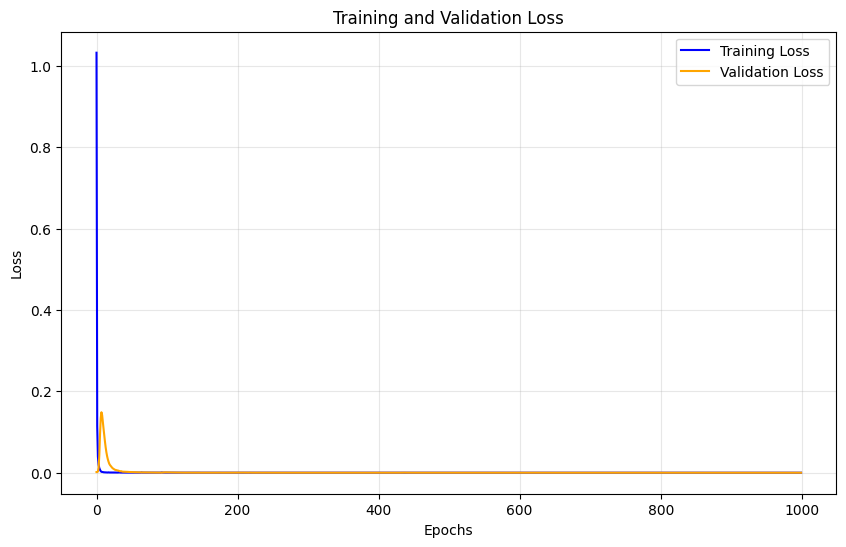

In [4]:
plot_loss(history)

# Prediction & Performance

In [5]:
# 2D Map 결과 도출을 위한 지도 파라미터 세팅
proj = '+proj=lcc +lat_1=30 +lat_2=60 +lon_1=126 +lat_0=38 +lon_0=126 +ellps=GRS80 +units=m'
atob = {
    0: 'G', 1: 'F', 2: 'K', 3: 'J', 4: 'E', 5: 'D',
    6: 'O', 7: 'C', 8: 'A', 9: 'Q', 10: 'P', 11: 'B',
    12: 'M', 13: 'L', 14: 'N', 15: 'I', 16: 'H'}
region_columns = {
    'A': 'Seoul City', 'B': 'Incheon City', 'C': 'Busan City', 'D': 'Daegu City',
    'E': 'Gwangju City', 'F': 'Gyeonggi-do', 'G': 'Gangwon-do', 'H': 'Chungbuk-do',
    'I': 'Chungnam-do', 'J': 'Gyeongbuk-do', 'K': 'Gyeongnam-do', 'L': 'Jeonbuk-do',
    'M': 'Jeonnam-do', 'N': 'Jeju-do', 'O': 'Daejeon City', 'P': 'Ulsan City', 'Q': 'Sejong City'}

def get_ctprvn_map() -> gpd.GeoDataFrame:
    path = '/home/user/workdir/CMAQ_Emulator/main/resources/geom/ctp_rvn.shp'
    ctprvn = gpd.GeoDataFrame.from_file(path, encoding='cp949')
    ctprvn.crs = 'EPSG:5179'
    return ctprvn

def get_base_raster(ctprvn:gpd.GeoDataFrame) -> gpd.GeoDataFrame:
    points = [Point(i, j)
                for i in range(-180000, -180000 + 9000 * 67, 9000)
                for j in range(-585000, -585000 + 9000 * 82, 9000)]
    grid_data = gpd.GeoDataFrame(points, geometry='geometry', columns=['geometry'])
    grid_data.crs = ctprvn.to_crs(proj).crs
    grid_data.loc[:,'x_m'] = grid_data.geometry.x
    grid_data.loc[:,'y_m'] = grid_data.geometry.y
    grid_data.loc[:,'value'] = 0
    grid_data.loc[:,'index'] = grid_data.index
    return grid_data

def get_region_pixel_indices() -> list:
    ctprvn = get_ctprvn_map()
    grid_data = get_base_raster(ctprvn)

    cities = {
        0: '강원도', 1: '경기도', 2: '경상남도', 3: '경상북도',
        4: '광주광역시', 5: '대구광역시', 6: '대전광역시', 7: '부산광역시',
        8: '서울특별시', 9: '세종특별자치시', 10: '울산광역시', 11: '인천광역시',
        12: '전라남도', 13: '전라북도', 14: '제주특별자치도', 15: '충청남도',
        16: '충청북도'
    }

    gdf_joined_loc = ['CTPRVN_CD', 'CTP_ENG_NM', 'CTP_KOR_NM', 'index_right0']
    gdf_joined = gpd.sjoin(ctprvn, grid_data.to_crs(5179), predicate='contains')

    indices = gpd.GeoDataFrame(pd.merge(
        left=grid_data, right=gdf_joined.loc[:,gdf_joined_loc], 
        how='left', left_on='index', right_on='index_right0'
    ), geometry='geometry').dropna()
    pixel_indices = \
        [[(idx%82, idx//82) for idx in indices.loc[indices.CTP_KOR_NM==cities[region]].index.tolist()]
         for region, _ in cities.items()]
    return pixel_indices

ctprvn = get_ctprvn_map()
ctprvn_proj = ctprvn.to_crs(proj)

# 건국대(서울대)에서 제공한 대한민국 국토 grid 정보
grid_alloc = (
    pd.read_csv('/home/user/workdir/CMAQ_Emulator/main/resources/geom/grid_allocation.csv') # load grid allocation data
    .sort_values(by=['Row', 'Column', 'Ratio'], ascending=[True, True, False]) # sort by row, column, ratio
    .drop_duplicates(subset=['Row', 'Column'], keep='first') # drop duplicates
    .reset_index(drop=True) # reset index
)

# 정부에서 배포하는 대한민국 국토 grid 정보
pixel_indices = get_region_pixel_indices()
total_index = []
for idx, grids in enumerate(pixel_indices):
    for grid in grids:
        total_index.append([
            grid[1], grid[0], 100.0, atob[idx], region_columns[atob[idx]]
        ])
total_index = pd.DataFrame(total_index, columns=grid_alloc.columns)

# 두 기관에서 주는 grid에 한두픽셀씩 비어있는 부분이 있어, 두 기관 데이터를 모두 참조하여 중복되는 픽셀을 정리 후 최종 국토 grid 정보를 취득
grid_alloc = pd.concat([
    grid_alloc.drop(columns=['Ratio', 'Region_Name']),
    total_index.drop(columns=['Ratio', 'Region_Name'])
]).sort_values(by=['Region_Code']).drop_duplicates().reset_index(drop=True)
grid_alloc[['Row', 'Column']] = grid_alloc[['Row', 'Column']] - 1

row_indices, col_indices = zip(*grid_alloc[['Row', 'Column']].values)
offset_x, offset_y = 4500, 4500 # 지도 위치 맞추기

# 마스킹 처리
mask = np.zeros((82, 67))
mask[row_indices, col_indices] = 1

cmap_white = mpl.colormaps['jet']
cmap_white.set_under('white')

In [7]:
test_split = 0.4  # 테스트 데이터 비율 (20%)
random_seed = 42  # 랜덤 시드
model = tf.keras.models.load_model('/home/user/workdir/CMAQ_Emulator/main/src/model/o3_prediction/v2/final_model')

pred_emis_data = []
pred_time_data = []
pred_boundary_data = []

# Load Test Data
dataset_2013 = pd.read_csv('/home/user/workdir/CMAQ_Emulator/main/resources/ctrl/precursor_control_2013.csv')
dataset_2013['Boundary'] = 1.0

ctrl_data = pd.concat([dataset_2013], axis=0)
ctrl_data = ctrl_data.reset_index(drop=True).values

base_path_2013 = "/home/user/workdir/CMAQ_Emulator/main/datasets/concentration/2013"

conc_path = []
for i in range(1, 120): 
    conc_path.append(os.path.join(base_path_2013, '1.00', f'ACONC.{i}'))

conc_data = []
for path in conc_path:
    with nc.Dataset(path) as f:
        conc_data.append(f.variables['O3'][:].data.squeeze())  # ncf 파일 내 목적변수를 지정 
conc_data = np.array(conc_data).reshape(len(conc_path), 82, 67, 1)
    
pred_emis_data, pred_boundary_data = ctrl_data[:, :17*5], ctrl_data[:, 17*5]

_, X_emis_test, _, X_boundary_test, _, y_test = train_test_split(pred_emis_data, pred_boundary_data, conc_data, test_size=test_split, random_state=random_seed)

y_preds = model.predict([X_emis_test,  X_boundary_test]) # 2가지 경계 조건에 따른 1년치 Nitrate
y_pred = y_preds.squeeze()
y_true = y_test.squeeze()

2/2 [==============================] - 2s 525ms/step


In [8]:
mask_expanded = np.repeat(mask[np.newaxis, :, :], repeats=y_true.shape[0], axis=0) # (24, 82, 67)

pred_conc_map_w_lines = np.where(mask_expanded == 1, y_pred, 0)  # 마스킹 적용
true_conc_map_w_lines = np.where(mask_expanded == 1, y_true, 0) # 마스킹 적용
print(y_pred.shape)
print(y_true.shape)
print(pred_conc_map_w_lines.shape)
print(true_conc_map_w_lines.shape)

(48, 82, 67)
(48, 82, 67)
(48, 82, 67)
(48, 82, 67)


In [9]:
def plot_scatter(ax, y_true, y_pred):
    r_x, r_y = np.polyfit(y_true, y_pred, 1)
    ax.hist2d(
        y_true, y_pred,
        bins=150, cmap='jet', cmin=1,
        norm=mpl.colors.LogNorm(vmin=1, vmax=1000),
    )
    ax.plot(
        y_true, r_x*y_true + r_y,
        color='red', label=f"y={r_x:.4f}x+{r_y:.4f}")
    r2 = r2_score(y_true, y_pred)
    ax.text(
        0.05, 0.95, f"$R^2={r2:.4f}$ \nSlope={r_x:.4f}\nIntercept={r_y:.4f}",
        verticalalignment='top', horizontalalignment='left',
        transform=ax.transAxes, fontsize=11
    )
    ax.grid(alpha=0.25)
    return ax

def get_score(y_true, y_pred):
    batch_size = y_true.shape[0]
    y_true = y_true.reshape(batch_size, -1)
    y_pred = y_pred.reshape(batch_size, -1)
    y_norm_err = np.abs(y_true - y_pred) / np.mean(y_true, axis=1, keepdims=True)
    y_err_mean = np.mean(y_norm_err, axis=1)
    y_err_std = np.percentile(y_norm_err, q=5, axis=1)
    return y_err_mean, y_err_std

In [10]:
print(y_pred.shape)
print(y_true.shape)
print(pred_conc_map_w_lines.shape)
print(true_conc_map_w_lines.shape)

(48, 82, 67)
(48, 82, 67)
(48, 82, 67)
(48, 82, 67)


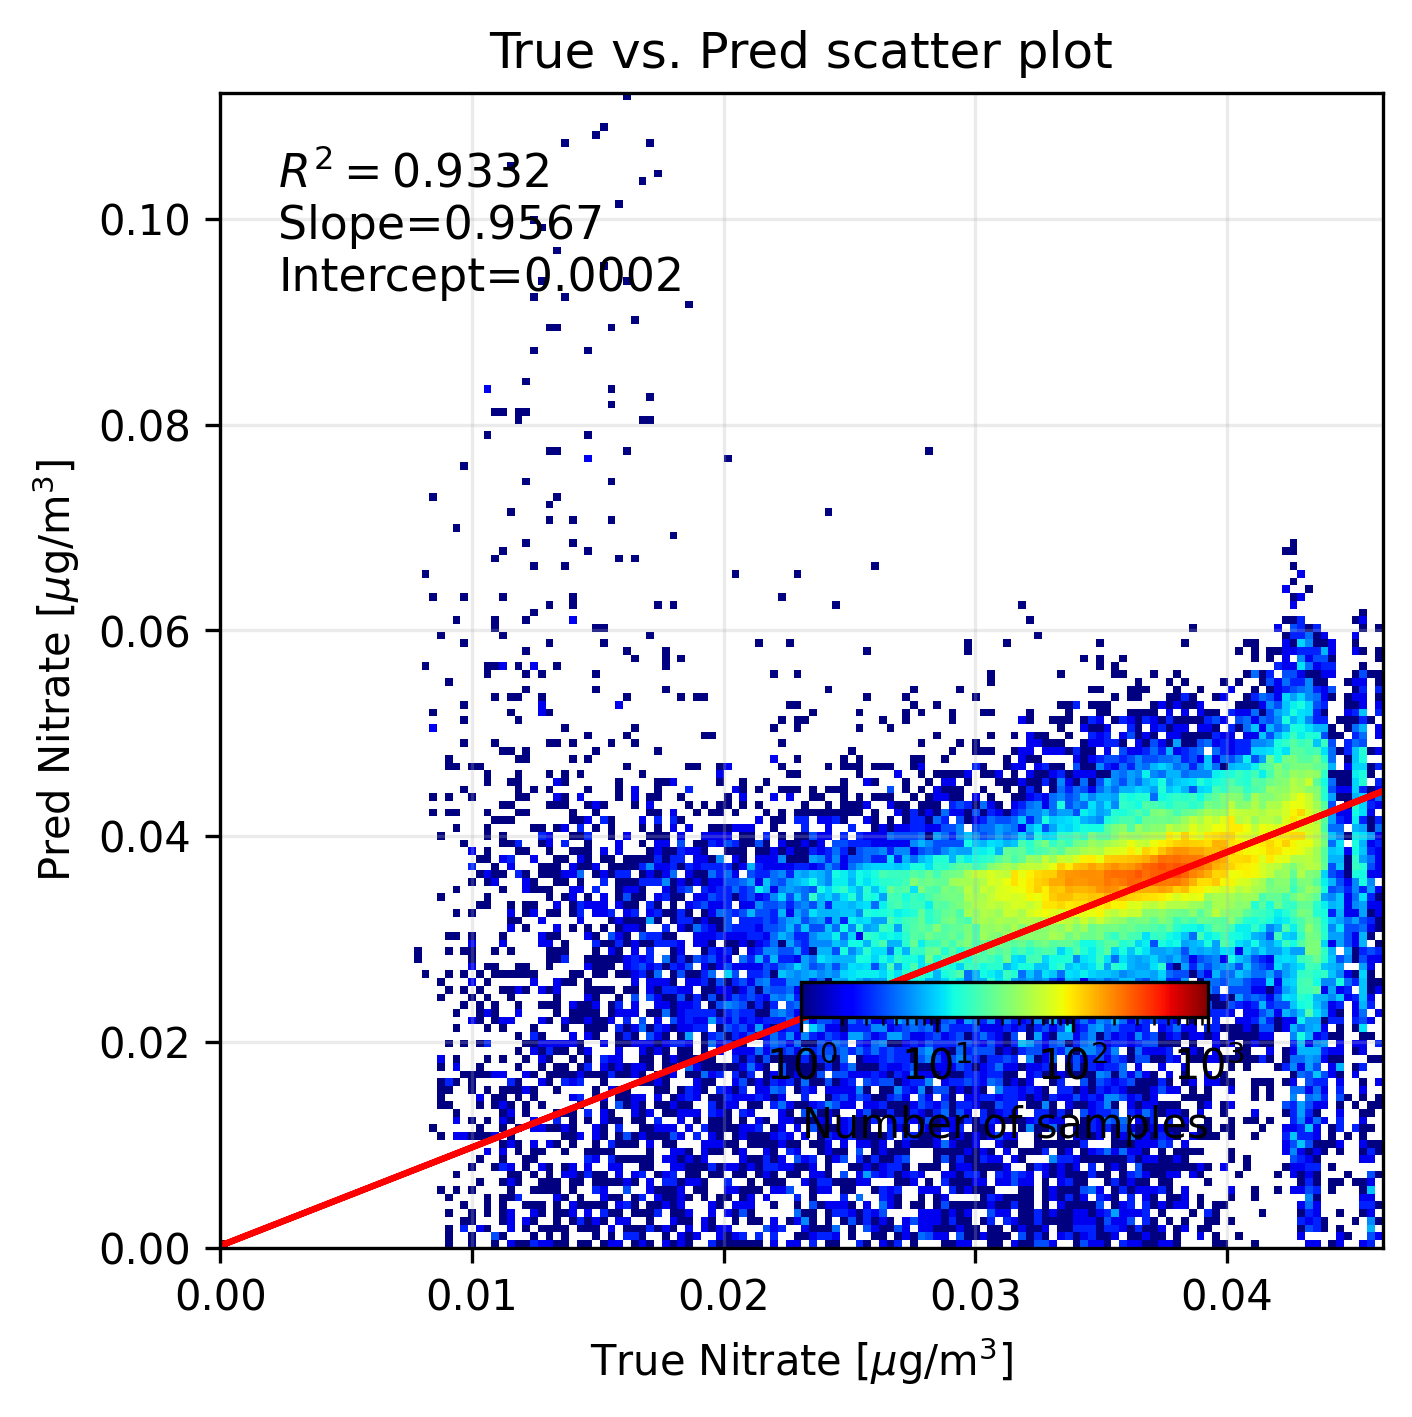

In [11]:
y_true_modi = true_conc_map_w_lines.reshape(-1)
y_pred_modi = pred_conc_map_w_lines.reshape(-1)

fig, axes = plt.subplots(1, 1, figsize=(5, 5), dpi=300)
axes = plot_scatter(axes, y_true_modi, y_pred_modi)
axes.grid(alpha=0.25)
axes.set_title("True vs. Pred scatter plot")
axes.set_xlabel('True Nitrate [$\mu \mathrm{g}/\mathrm{m}^3$]')
axes.set_ylabel('Pred Nitrate [$\mu \mathrm{g}/\mathrm{m}^3$]')
cbaxes = axes.inset_axes([0.5, 0.2, 0.35, 0.03])
cb = plt.colorbar(
    mpl.cm.ScalarMappable(norm=mpl.colors.LogNorm(vmin=1, vmax=1000), cmap='jet'),
    cax=cbaxes, label='Number of samples', orientation='horizontal')
cb.set_label(label='Number of samples', fontsize=10)

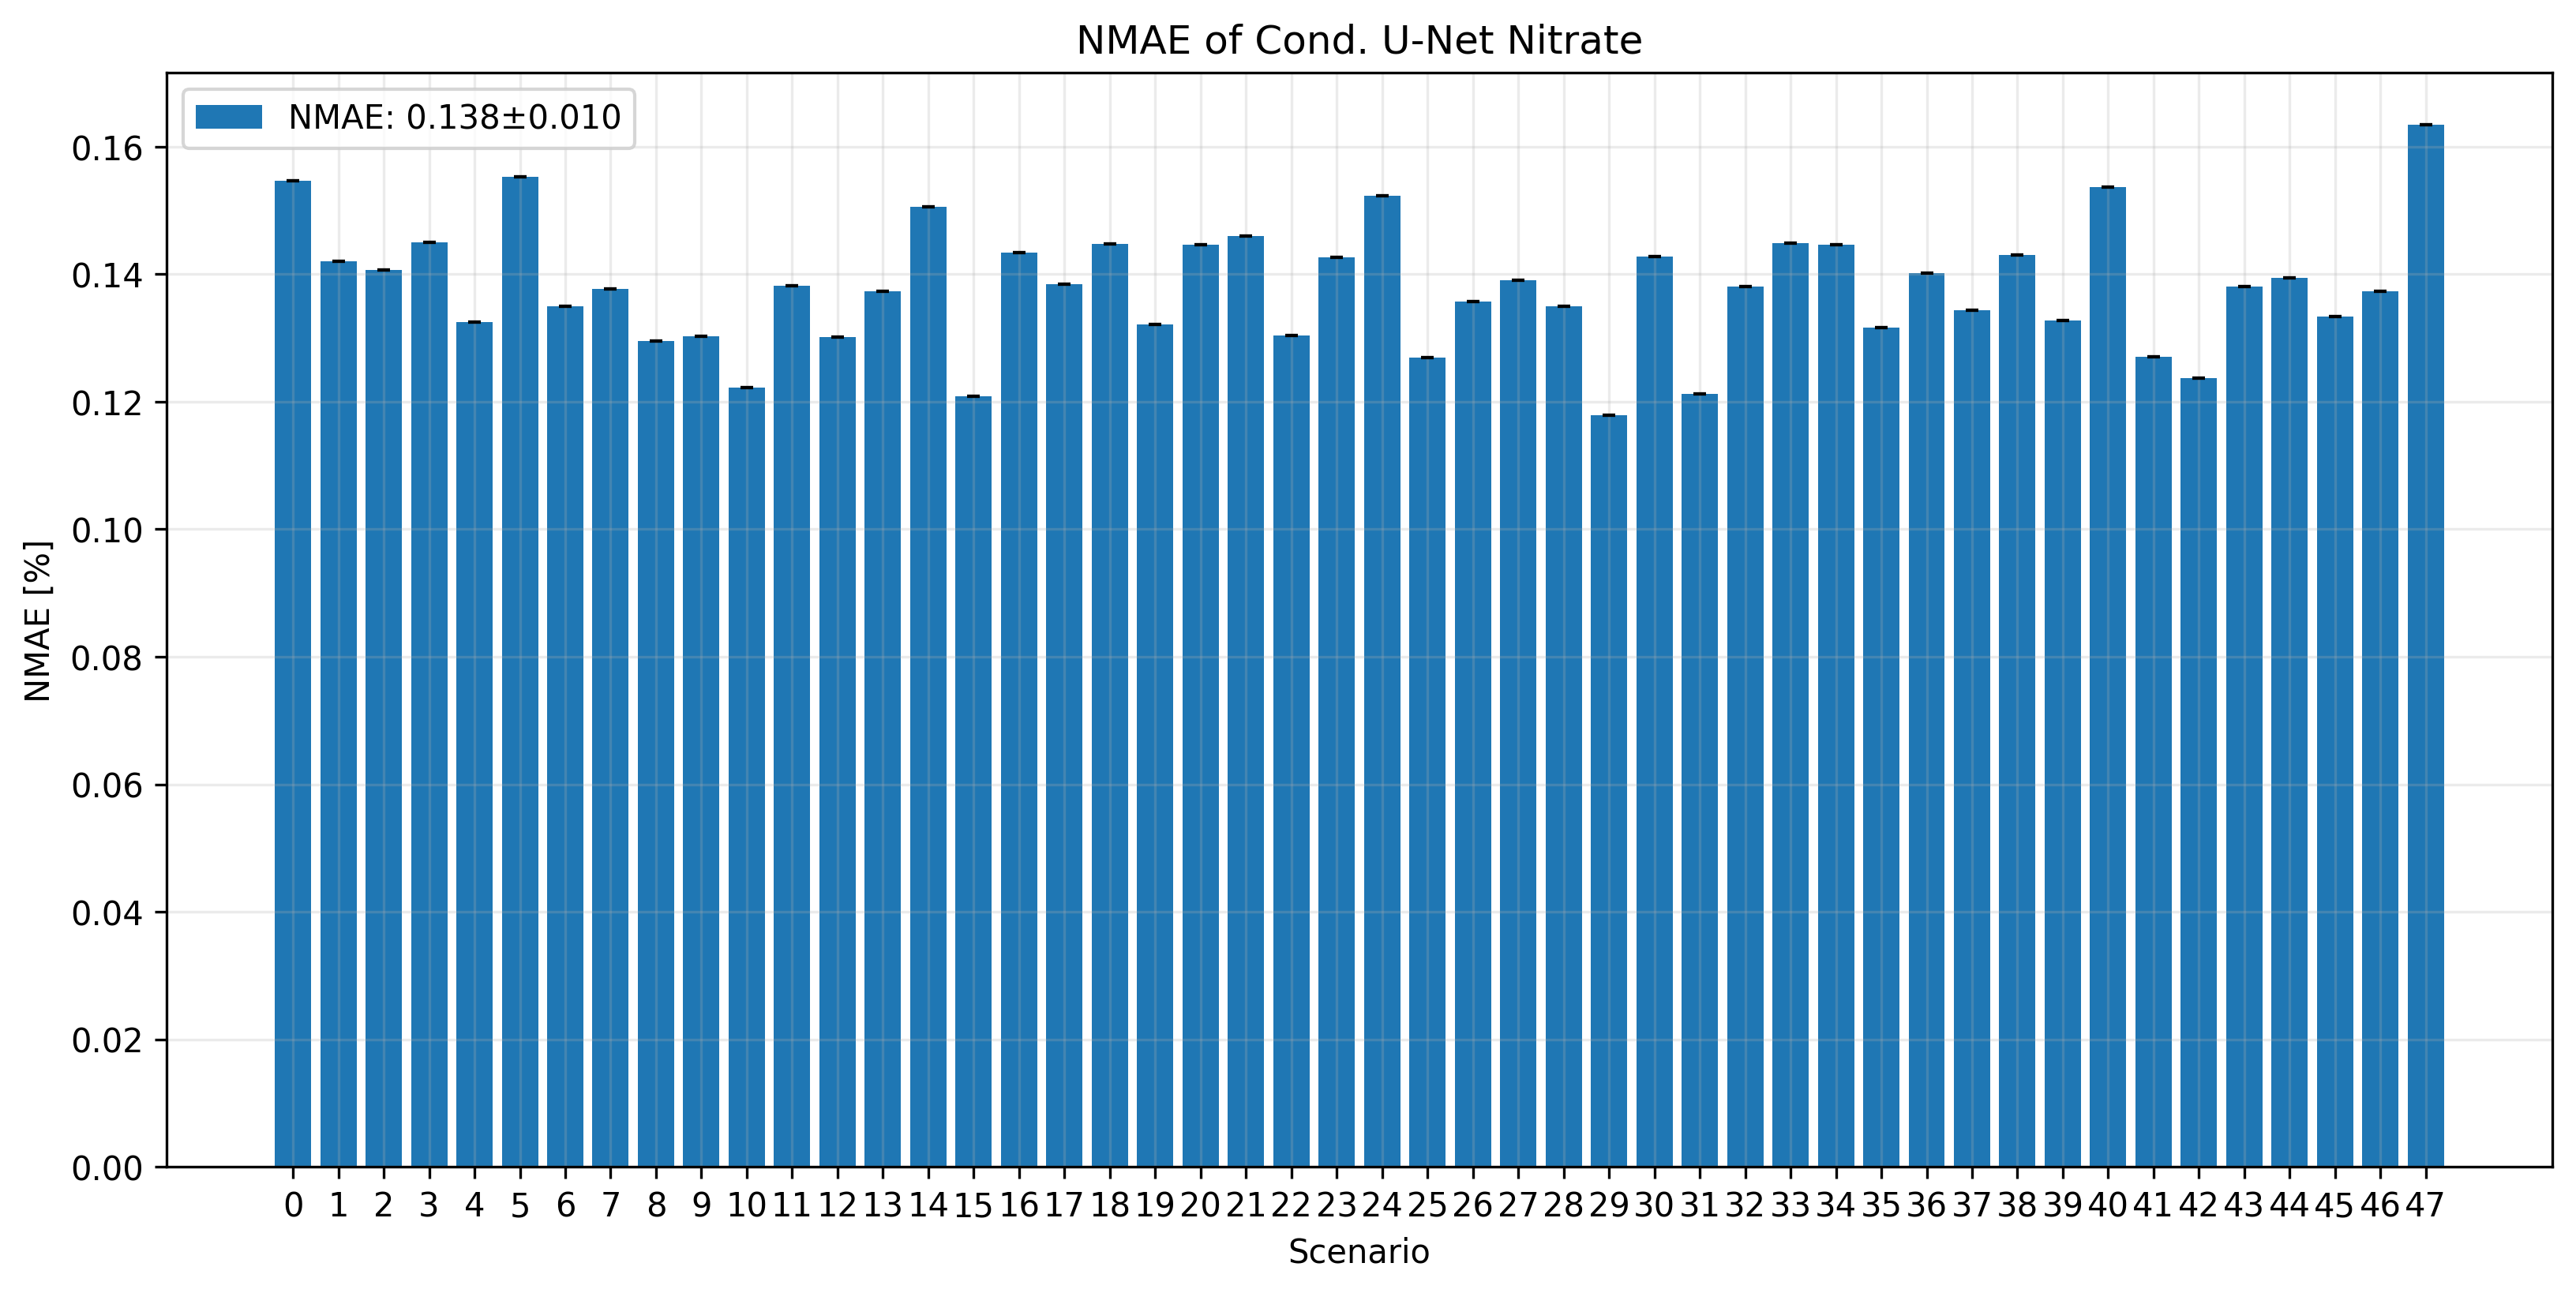

In [12]:
fig, axes = plt.subplots(1, 1, figsize=(13, 6), dpi=300)
score, score_std = get_score(true_conc_map_w_lines, pred_conc_map_w_lines)
label_text = f'NMAE: {np.mean(score):.3f}±{np.std(score):.3f}'

axes.bar(np.arange(y_test.shape[0]), score, yerr=score_std, label=label_text, capsize=2)
axes.set_xticks(np.arange(y_test.shape[0]), range(y_test.shape[0]))
axes.grid(alpha=0.25)
axes.legend()
axes.set_title("NMAE of Cond. U-Net Nitrate")
axes.set_xlabel('Scenario')
axes.set_ylabel('NMAE [%]')
plt.show()

In [ ]:
# np.set_printoptions(threshold=sys.maxsize)
# print(true_conc_map_w_lines[17])

[17]


/tmp/ipykernel_1812514/1207372777.py:28: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[i, 0].set_xticklabels([f"{i}" for i in range(124, 132, 1)])
/tmp/ipykernel_1812514/1207372777.py:29: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[i, 0].set_yticklabels([f"{i}" for i in range(32, 40, 1)])
/tmp/ipykernel_1812514/1207372777.py:47: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[i, 1].set_xticklabels([f"{i}" for i in range(124, 132, 1)])
/tmp/ipykernel_1812514/1207372777.py:48: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[i, 1].set_yticklabels([f"{i}" for i in range(32, 40, 1)])
/tmp/ipykernel_1812514/1207372777.py:67: UserWarning: set_ti

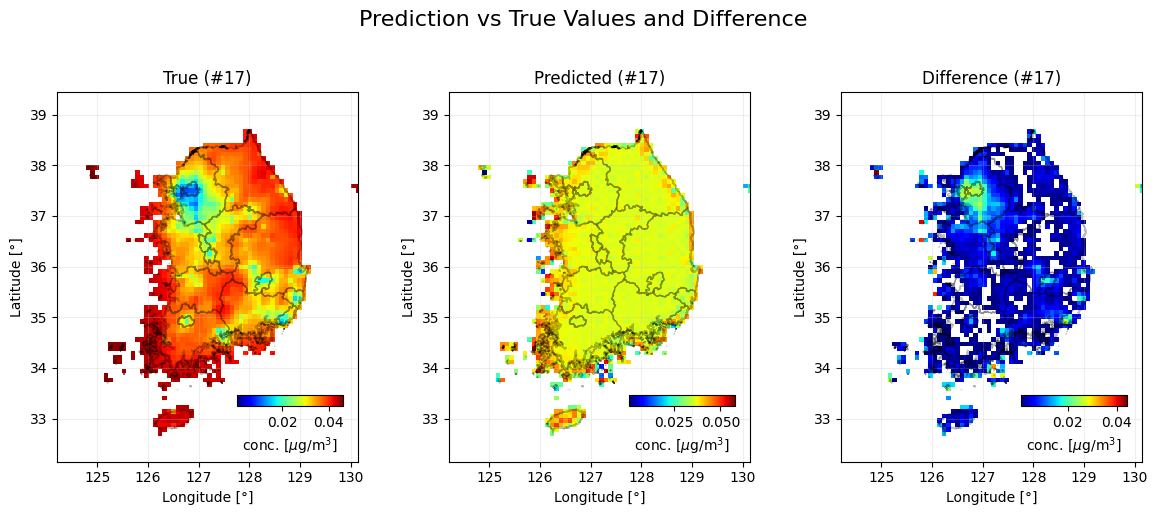

In [13]:
def plot_prediction_loss(y_true, y_pred, num_samples=1, indices=-1):
    if indices == -1 or indices < 0:
        indices = np.random.choice(len(y_true), num_samples, replace=False)
    else:
        index = indices
        indices = []
        indices.append(index) 
    print(indices)  # 선택된 인덱스 확인
    fig, axes = plt.subplots(num_samples, 3, figsize=(15, 5 * num_samples))
    if num_samples == 1:
        axes = np.expand_dims(axes, axis=0)  # 2차원으로 변환

    fig.suptitle("Prediction vs True Values and Difference", fontsize=16, y=1.02)
    for i, idx in enumerate(indices):
        # True 이미지
        axes[i, 0].imshow(
            y_true[idx][::-1], 
            cmap=cmap_white,
            extent=(-180000+offset_x, 414000+offset_x, -585000+offset_y, 144000+offset_y),
            vmin=0.001)
        axes[i, 0] = ctprvn_proj.boundary.plot(ax=axes[i, 0], edgecolor='black', facecolor='none', linewidth=1, alpha=0.25)
        axes[i, 0].set_xlim(-180000, 414000)
        axes[i, 0].set_ylim(-585000, 144000)
        axes[i, 0].set_xlabel('Longitude [°]')
        axes[i, 0].set_ylabel('Latitude [°]')
        axes[i, 0].set_title(f"True (#{idx})")
        axes[i, 0].grid(alpha=0.25, color='silver')
        axes[i, 0].set_xticklabels([f"{i}" for i in range(124, 132, 1)])
        axes[i, 0].set_yticklabels([f"{i}" for i in range(32, 40, 1)])
        cbaxes = axes[i, 0].inset_axes([0.6, 0.15, 0.35, 0.03])
        cb = plt.colorbar(axes[i, 0].images[0], cax=cbaxes, orientation='horizontal', label='Nitrate ($\mu g/m^3$)')
        cb.set_label(label='conc. [$\mu \mathrm{g}/\mathrm{m}^3$]')

        # Predicted 이미지
        axes[i, 1].imshow(
            y_pred[idx][::-1], 
            cmap=cmap_white,
            extent=(-180000+offset_x, 414000+offset_x, -585000+offset_y, 144000+offset_y),
            vmin=0.001)
        axes[i, 1] = ctprvn_proj.boundary.plot(ax=axes[i, 1], edgecolor='black', facecolor='none', linewidth=1, alpha=0.25)
        axes[i, 1].set_xlim(-180000, 414000)
        axes[i, 1].set_ylim(-585000, 144000)
        axes[i, 1].set_xlabel('Longitude [°]')
        axes[i, 1].set_ylabel('Latitude [°]')
        axes[i, 1].set_title(f"Predicted (#{idx})")
        axes[i, 1].grid(alpha=0.25, color='silver')
        axes[i, 1].set_xticklabels([f"{i}" for i in range(124, 132, 1)])
        axes[i, 1].set_yticklabels([f"{i}" for i in range(32, 40, 1)])
        cbaxes = axes[i, 1].inset_axes([0.6, 0.15, 0.35, 0.03])
        cb = plt.colorbar(axes[i, 1].images[0], cax=cbaxes, orientation='horizontal', label='Nitrate ($\mu g/m^3$)')
        cb.set_label(label='conc. [$\mu \mathrm{g}/\mathrm{m}^3$]')
        
        # Difference 이미지
        difference = np.abs(y_true[idx] - y_pred[idx])  # 차이 절대값
        axes[i, 2].imshow(
            difference[::-1], 
            cmap=cmap_white,
            extent=(-180000+offset_x, 414000+offset_x, -585000+offset_y, 144000+offset_y),
            vmin=0.001)
        axes[i, 2] = ctprvn_proj.boundary.plot(ax=axes[i, 2], edgecolor='black', facecolor='none', linewidth=1, alpha=0.25)
        axes[i, 2].set_xlim(-180000, 414000)
        axes[i, 2].set_ylim(-585000, 144000)
        axes[i, 2].set_xlabel('Longitude [°]')
        axes[i, 2].set_ylabel('Latitude [°]')
        axes[i, 2].set_title(f"Difference (#{idx})")
        axes[i, 2].grid(alpha=0.25, color='silver')
        axes[i, 2].set_xticklabels([f"{i}" for i in range(124, 132, 1)])
        axes[i, 2].set_yticklabels([f"{i}" for i in range(32, 40, 1)])
        cbaxes = axes[i, 2].inset_axes([0.6, 0.15, 0.35, 0.03])
        cb = plt.colorbar(axes[i, 2].images[0], cax=cbaxes, orientation='horizontal', label='Nitrate ($\mu g/m^3$)')
        cb.set_label(label='conc. [$\mu \mathrm{g}/\mathrm{m}^3$]')
        
    plt.tight_layout(rect=[0, 0, 1, 1])
    plt.subplots_adjust(wspace=-0.4, hspace=0.2)
    plt.show()

plot_prediction_loss(true_conc_map_w_lines, pred_conc_map_w_lines, indices=17)

In [14]:
true_conc_map_w_lines_re = true_conc_map_w_lines
pred_conc_map_w_lines_re = pred_conc_map_w_lines

true_conc_map_w_lines_re = np.delete(true_conc_map_w_lines, 17, axis=0)
pred_conc_map_w_lines_re = np.delete(pred_conc_map_w_lines, 17, axis=0)

print(true_conc_map_w_lines_re.shape)
print(pred_conc_map_w_lines_re.shape)

(47, 82, 67)
(47, 82, 67)


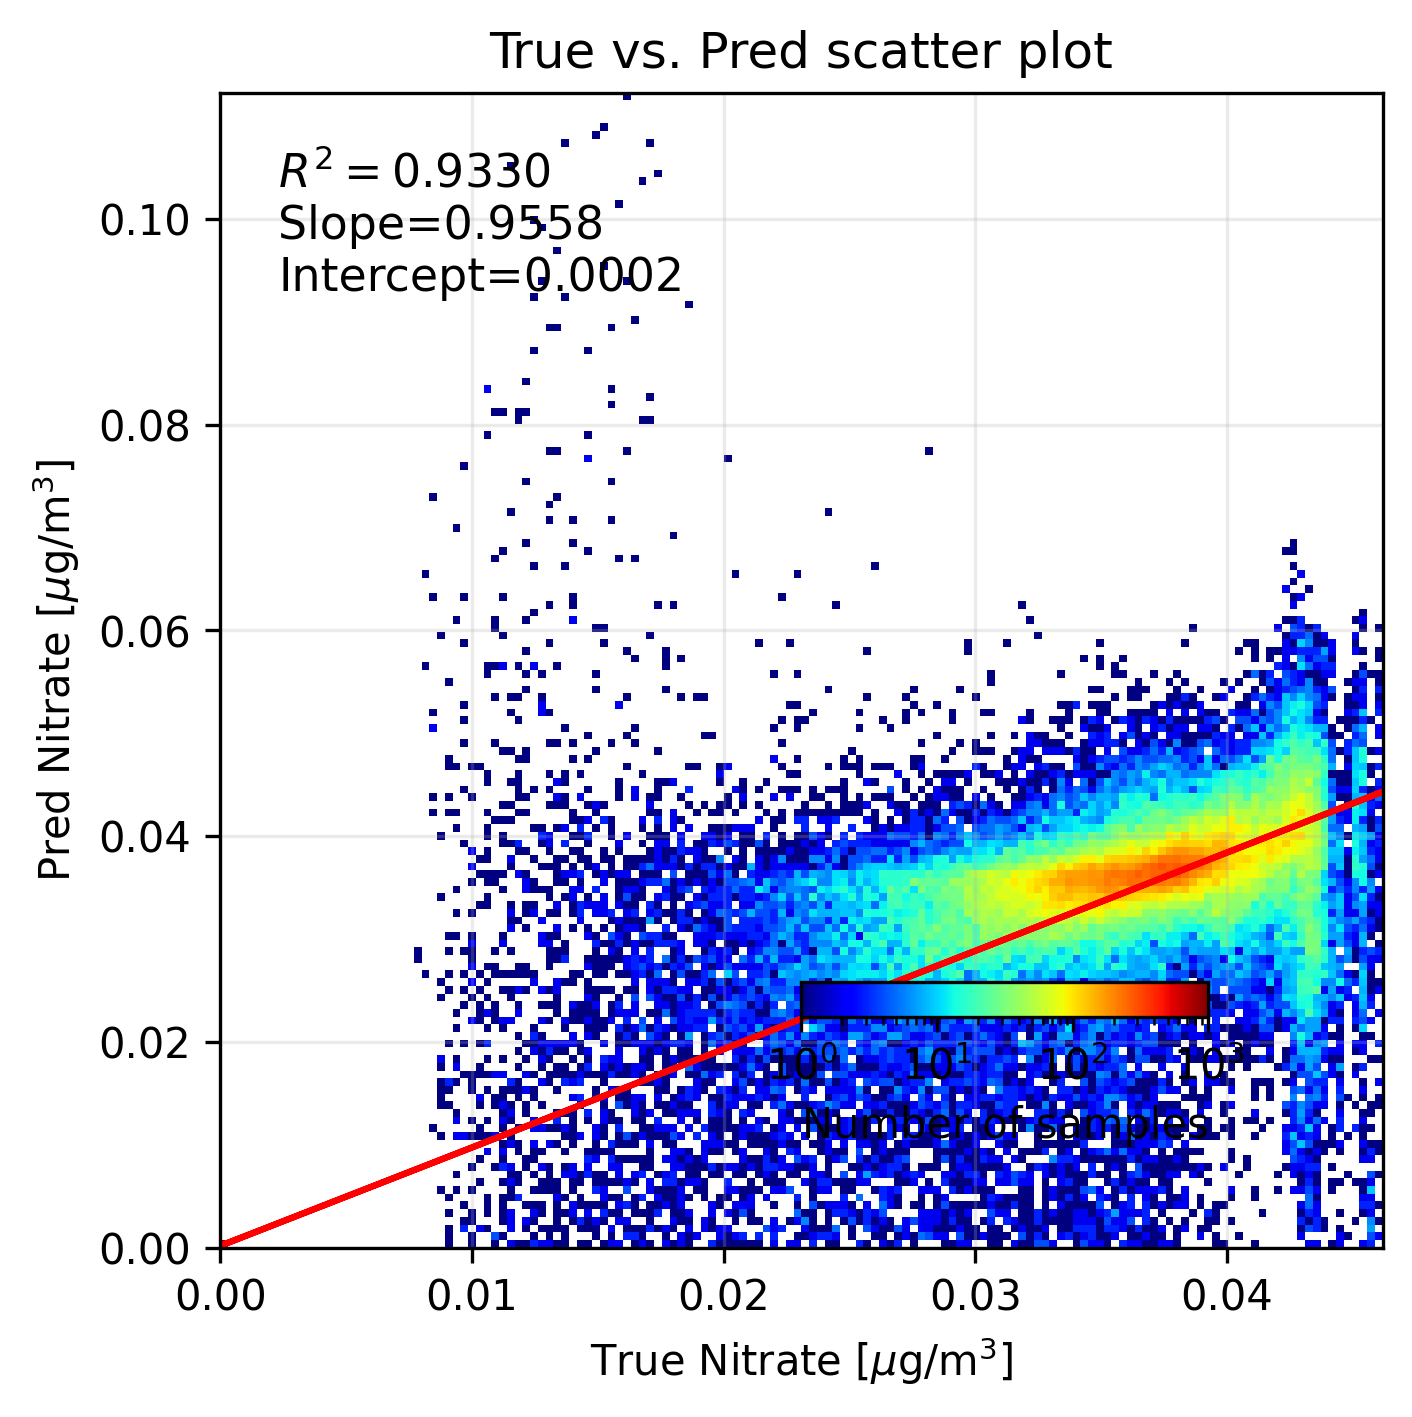

In [15]:
y_true_modi = true_conc_map_w_lines_re.reshape(-1)
y_pred_modi = pred_conc_map_w_lines_re.reshape(-1)

fig, axes = plt.subplots(1, 1, figsize=(5, 5), dpi=300)
axes = plot_scatter(axes, y_true_modi, y_pred_modi)
axes.grid(alpha=0.25)
axes.set_title("True vs. Pred scatter plot")
axes.set_xlabel('True Nitrate [$\mu \mathrm{g}/\mathrm{m}^3$]')
axes.set_ylabel('Pred Nitrate [$\mu \mathrm{g}/\mathrm{m}^3$]')
cbaxes = axes.inset_axes([0.5, 0.2, 0.35, 0.03])
cb = plt.colorbar(
    mpl.cm.ScalarMappable(norm=mpl.colors.LogNorm(vmin=1, vmax=1000), cmap='jet'),
    cax=cbaxes, label='Number of samples', orientation='horizontal')
cb.set_label(label='Number of samples', fontsize=10)

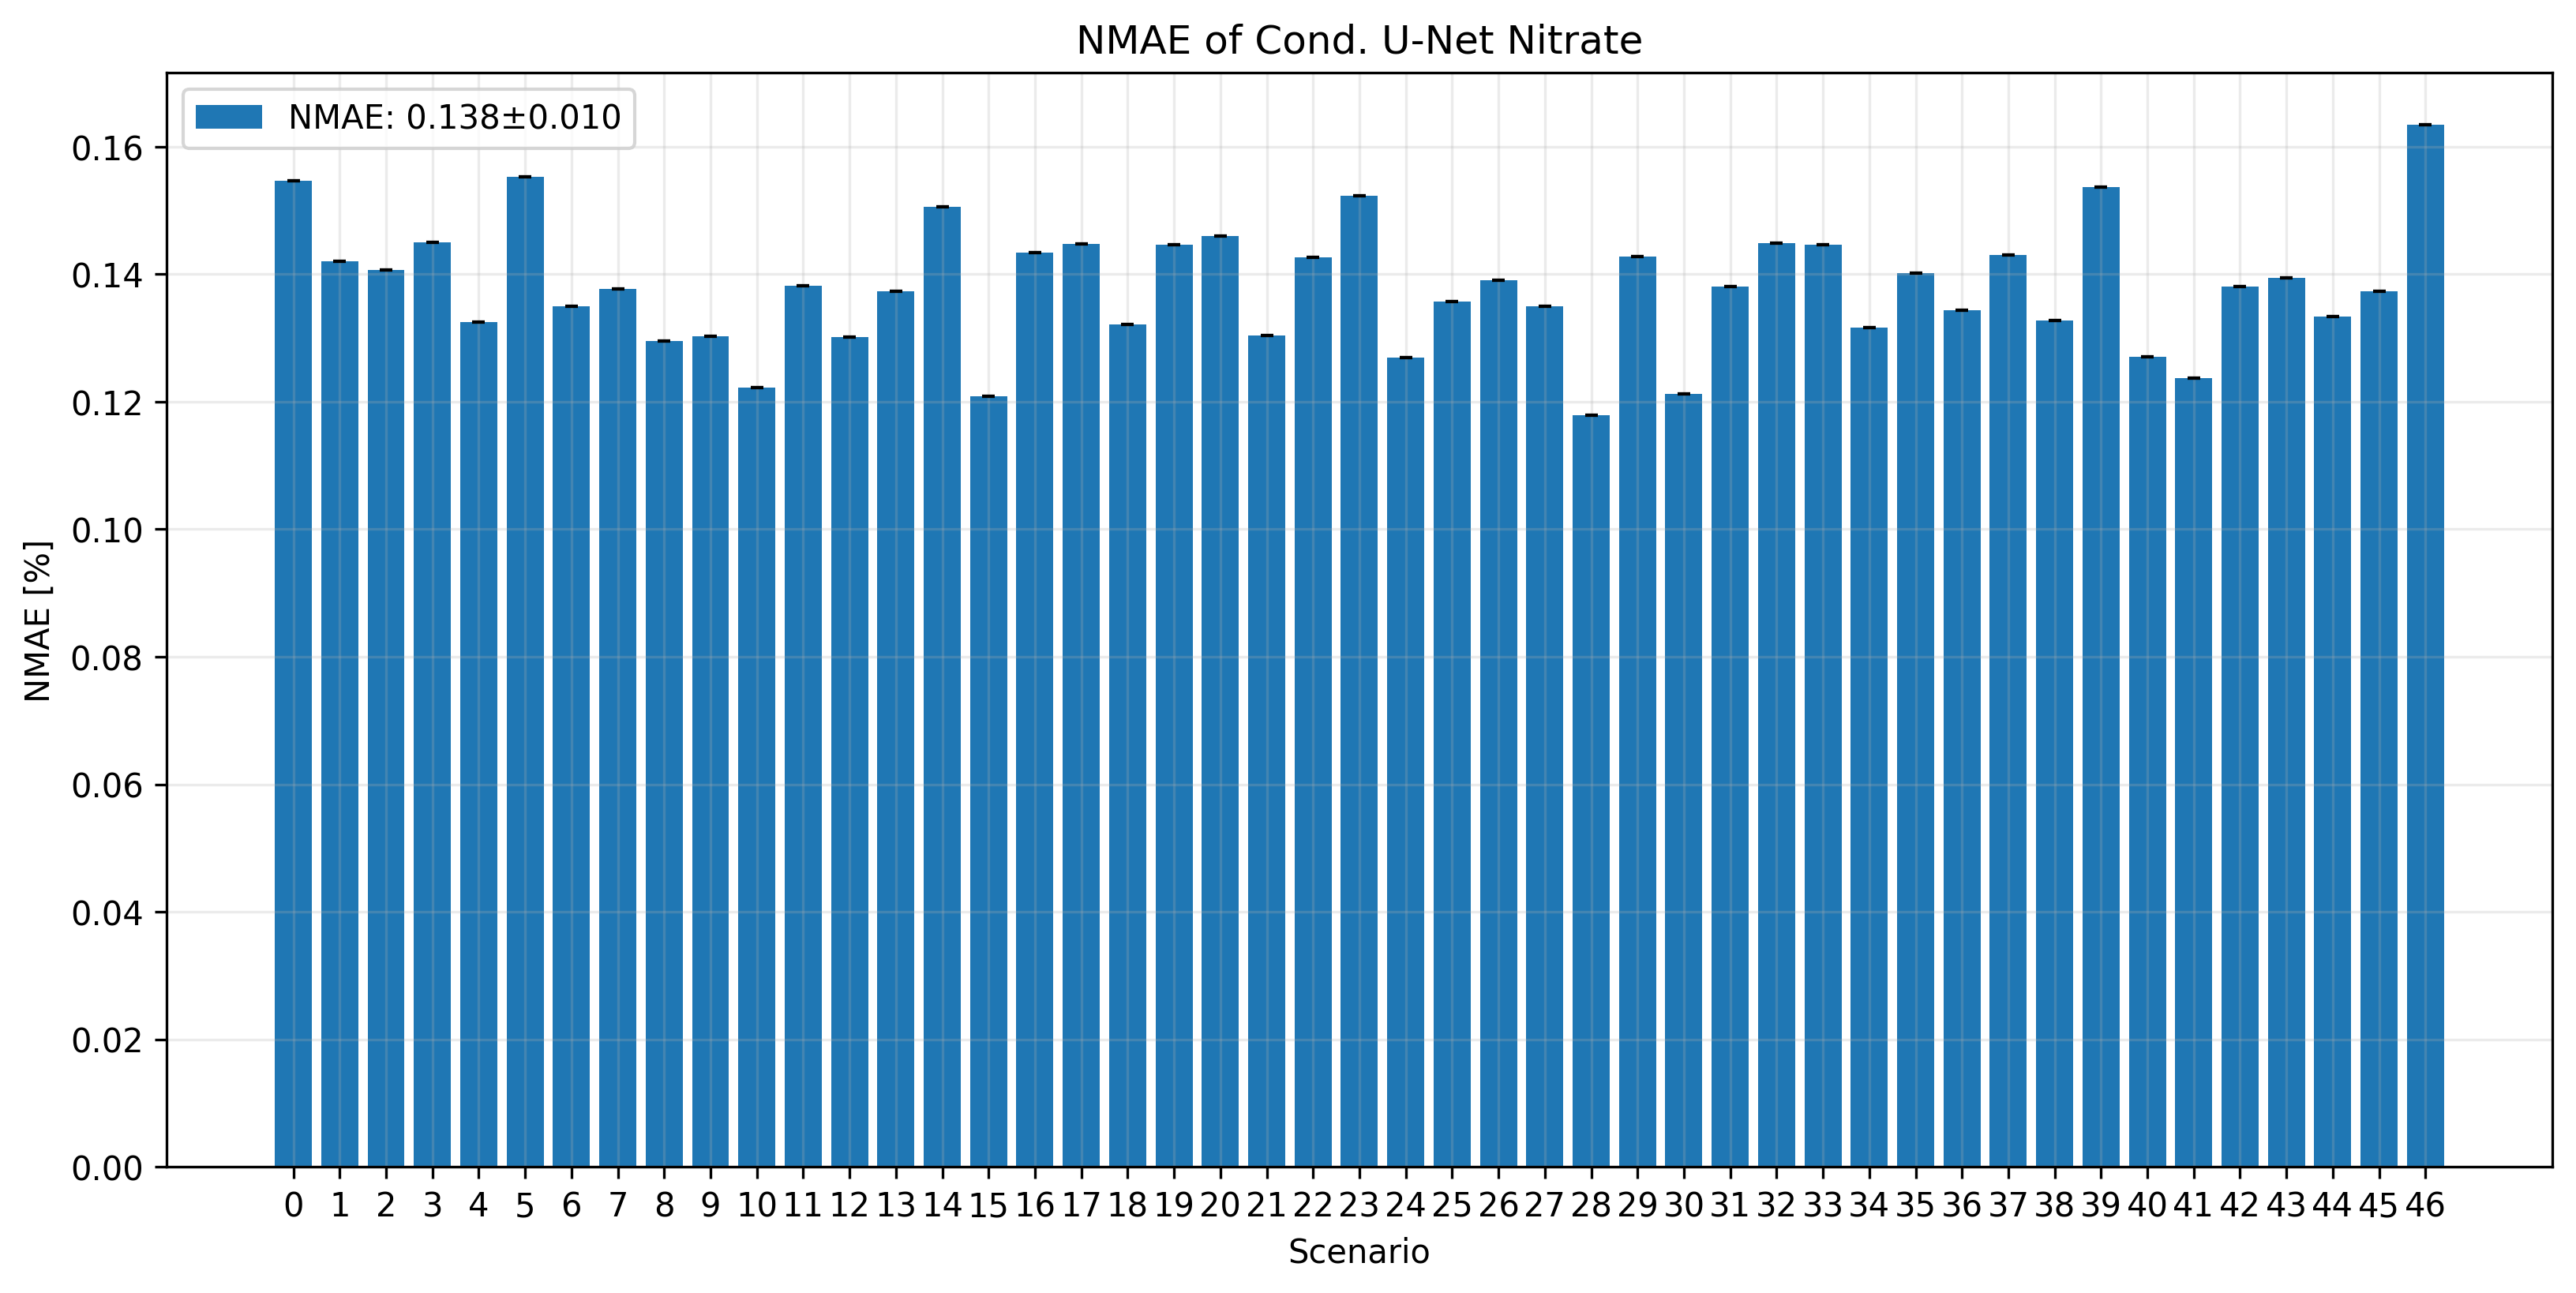

In [16]:
fig, axes = plt.subplots(1, 1, figsize=(13, 6), dpi=300)
score, score_std = get_score(true_conc_map_w_lines_re, pred_conc_map_w_lines_re)
label_text = f'NMAE: {np.mean(score):.3f}±{np.std(score):.3f}'

axes.bar(np.arange(y_test.shape[0]-1), score, yerr=score_std, label=label_text, capsize=2)
axes.set_xticks(np.arange(y_test.shape[0]-1), range(y_test.shape[0]-1))
axes.grid(alpha=0.25)
axes.legend()
axes.set_title("NMAE of Cond. U-Net Nitrate")
axes.set_xlabel('Scenario')
axes.set_ylabel('NMAE [%]')
plt.show()